# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# Problem Understanding

# Part 2 - EDA and Data Preparation for Modelling

## 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helpers as h

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2. Load Data

In [2]:
transcript_clean, transcript_all = h.transcript_preprocessing(transcript, profile, portfolio)

The transcript_clean.csv and transcript_merge.csv file are available at local folder


In [3]:
transcript_clean.head(5)

event                            person  time  \
Unnamed: 0                                                           
0           offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1           offer received  a03223e636434f42ac4c3df47e8bac43     0   
2           offer received  e2127556f4f64592b11af22de27a7932     0   
3           offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4           offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                                       value  \
Unnamed: 0                                                     
0           {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1           {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2           {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3           {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4           {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                                    offer_id  amount  age became_member_on  \
Unnamed: 0                                                                   
0           9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   75       2017-05-09   
1           0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  118       2017-08-04   
2           2906b810c7d4411798c6938adc9daaa5     NaN   68       2018-04-26   
3           fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-25   
4           4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  118       2017-10-02   

           gender    income  difficulty  duration offer_type  reward  \
Unnamed: 0                                                             
0               F  100000.0         5.0       7.0       bogo     5.0   
1             NaN       NaN        20.0      10.0   discount     5.0   
2               M   70000.0        10.0       7.0   discount     2.0   
3             NaN       NaN        10.0      10.0   discount     2.0   
4             NaN       NaN        10.0       5.0       bogo    10.0   

                        name  web  email  mobile  social  invalid  
Unnamed: 0                                                         
0                 bogo_5_5_7  1.0    1.0     1.0     0.0      0.0  
1           discount_20_5_10  1.0    1.0     0.0     0.0      0.0  
2            discount_10_2_7  1.0    1.0     1.0     0.0      0.0  
3           discount_10_2_10  1.0    1.0     1.0     1.0      0.0  
4               bogo_10_10_5  1.0    1.0     1.0     1.0      0.0

In [4]:
transcript_all.head(5)

event                            person  time  \
0  offer received  78afa995795e4d85b5d9ceeca43f5fef     0   
1  offer received  a03223e636434f42ac4c3df47e8bac43     0   
2  offer received  e2127556f4f64592b11af22de27a7932     0   
3  offer received  8ec6ce2a7e7949b1bf142def7d0e0586     0   
4  offer received  68617ca6246f4fbc85e91a2a49552598     0   

                                              value  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}   

                           offer_id  amount  age became_member_on gender  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN   75       2017-05-09      F   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  118       2017-08-04   None   
2  2906b810c7d4411798c6938adc9daaa5     NaN   68       2018-04-26      M   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  118       2017-09-25   None   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN  118       2017-10-02   None   

     income  difficulty  duration offer_type  reward              name  web  \
0  100000.0         5.0       7.0       bogo     5.0        bogo_5_5_7  1.0   
1       NaN        20.0      10.0   discount     5.0  discount_20_5_10  1.0   
2   70000.0        10.0       7.0   discount     2.0   discount_10_2_7  1.0   
3       NaN        10.0      10.0   discount     2.0  discount_10_2_10  1.0   
4       NaN        10.0       5.0       bogo    10.0      bogo_10_10_5  1.0   

   email  mobile  social  invalid  
0    1.0     1.0     0.0      0.0  
1    1.0     0.0     0.0      0.0  
2    1.0     1.0     0.0      0.0  
3    1.0     1.0     1.0      0.0  
4    1.0     1.0     1.0      0.0

## 3. Feature Extraction from data

In [3]:
#import helpers as h
profile_updated = h.feature_extraction(transcript_clean,profile, portfolio)

The profile_updated.csv file is available at local folder.


In [5]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7      ...       \
Unnamed: 0                                                           ...        
68be06ca386d4c31939f3a4f0e3dd783                            1.0      ...        
0610b486422d4921ae7d2bf64640c50b                            0.0      ...        
38fe809add3b4fcf9315a9694bb96ff5                            0.0      ...        
78afa995795e4d85b5d9ceeca43f5fef                            0.0      ...        
a03223e636434f42ac4c3df47e8bac43                            0.0      ...        

                                  bogo_10_10_5_response_time_avg  \
Unnamed: 0                                                         
68be06ca386d4c31939f3a4f0e3dd783                             NaN   
0610b486422d4921ae7d2bf64640c50b                             NaN   
38fe809add3b4fcf9315a9694bb96ff5                             NaN   
78afa995795e4d85b5d9ceeca43f5fef                             NaN   
a03223e636434f42ac4c3df47e8bac43                             NaN   

                                  bogo_5_5_7_response_time_avg  \
Unnamed: 0                                            

In [6]:
profile_updated.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, 68be06ca386d4c31939f3a4f0e3dd783 to e4052622e5ba45a8b96b59aba68cf068
Data columns (total 43 columns):
age                                   17000 non-null int64
became_member_on                      17000 non-null datetime64[ns]
gender                                14825 non-null object
income                                14825 non-null float64
offer received_bogo_10_10_7           17000 non-null float64
offer received_bogo_10_10_5           17000 non-null float64
offer received_informational_0_0_4    17000 non-null float64
offer received_bogo_5_5_7             17000 non-null float64
offer received_discount_20_5_10       17000 non-null float64
offer received_discount_7_3_7         17000 non-null float64
offer received_discount_10_2_10       17000 non-null float64
offer received_informational_0_0_3    17000 non-null float64
offer received_bogo_5_5_5             17000 non-null float64
offer received_discount_10_2_7        170

## 4. Adding new features

In [4]:
""" Add information 'invalid' columns means how many each customer make trancsaction without influenced by the offer """

person_invalid = transcript_all[transcript_all.invalid == 1].person.value_counts()
person_invalid.head()

a18461ce01d340eb8704bf7fb692c6ba    6
cf7cd076d6484830b15e97bf82eafa2d    5
8836295fb69f4c53aa23c7b614cff7bf    5
91cec8d70c5a4c5aa04a0ee01653e5ad    5
05a009c95e8d477cbed5c1661343bbb9    5
Name: person, dtype: int64

In [5]:
# create new feature 'invalid', how many invalid transaction made by customer (transaction that not influenced by offer)
profile_updated['invalid'] = person_invalid
profile_updated['invalid'] = profile_updated['invalid'].fillna(0)
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7   ...     \
Unnamed: 0                                                        ...      
68be06ca386d4c31939f3a4f0e3dd783                            1.0   ...      
0610b486422d4921ae7d2bf64640c50b                            0.0   ...      
38fe809add3b4fcf9315a9694bb96ff5                            0.0   ...      
78afa995795e4d85b5d9ceeca43f5fef                            0.0   ...      
a03223e636434f42ac4c3df47e8bac43                            0.0   ...      

                                  bogo_5_5_7_response_time_avg  \
Unnamed: 0                                                       
68be06ca386d4c31939f3a4f0e3dd783                           NaN   
0610b486422d4921ae7d2bf64640c50b                           NaN   
38fe809add3b4fcf9315a9694bb96ff5                           NaN   
78afa995795e4d85b5d9ceeca43f5fef                         126.0   
a03223e636434f42ac4c3df47e8bac43                           NaN   

                                  discount_20_5_10_response_time_avg  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0

In [6]:
""" 
Create features
    - Total Count of the offer received, reviewed, completed for each type of portfolio (bogo, discount, and informational)
    - Rates for each offering type (bogo/discount/informational) : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received

"""


for offer in ['bogo', 'discount', 'informational']:
    received_cols = profile_updated.columns[(profile_updated.columns.str.contains('received_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate' ))].tolist()
    profile_updated[offer +'_received'] = profile_updated[received_cols].sum(axis=1).fillna(0)
    
    viewed_cols = profile_updated.columns[(profile_updated.columns.str.contains('viewed_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate'))].tolist()
    profile_updated[offer +'_viewed'] = profile_updated[viewed_cols].sum(axis=1).fillna(0)
    
    profile_updated['rate_viewed_' + offer] = (profile_updated[offer +'_viewed'] / profile_updated[offer +'_received']).fillna(0)
    
    if offer != 'informational':
        completed_cols = profile_updated.columns[(profile_updated.columns.str.contains('completed_' + offer)) & \
                                            (~profile_updated.columns.str.contains('rate' ))].tolist()
        profile_updated[offer +'_completed'] = profile_updated[completed_cols].sum(axis=1).fillna(0)
        
        profile_updated['rate_completed_viewed_' + offer] = \
                    (profile_updated[offer +'_completed'] /profile_updated[offer +'_viewed']).fillna(0)
        profile_updated['rate_completed_received_' + offer] = \
                    (profile_updated[offer +'_completed'] / profile_updated[offer +'_received']).fillna(0)

In [10]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
0610b486422d4921ae7d2bf64640c50b                            0.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   

                                            ...              \
Unnamed: 0                                  ...               
68be06ca386d4c31939f3a4f0e3dd783            ...               
0610b486422d4921ae7d2bf64640c50b            ...               
38fe809add3b4fcf9315a9694bb96ff5            ...               
78afa995795e4d85b5d9ceeca43f5fef            ...               
a03223e636434f42ac4c3df47e8bac43            ...               

                                  rate_completed_received_bogo  \
Unnamed: 0                                                       
68be06ca386d4c31939f3a4f0e3dd783                      0.000000   
0610b486422d4921ae7d2bf64640c50b                      0

In [7]:
""" 
Create Feature :
- Total count of received, viewed, completed
- Overall Rates : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received
        
"""
profile_updated['offer_received_total'] = profile_updated.bogo_received + profile_updated.discount_received + \
                                        profile_updated.informational_received

profile_updated['offer_viewed_total'] = profile_updated.bogo_viewed + profile_updated.discount_viewed + \
                                        profile_updated.informational_viewed

profile_updated['offer_completed_total'] = profile_updated.bogo_completed + profile_updated.discount_completed 

profile_updated['rate_offer_viewed_overall'] = \
        (profile_updated['offer_viewed_total'] / profile_updated['offer_received_total']).fillna(0)

profile_updated['rate_offer_completed_received_overall'] = \
        (profile_updated['offer_completed_total'] / profile_updated['offer_received_total']).fillna(0)

profile_updated['rate_offer_completed_viewed_overall'] = \
        (profile_updated['offer_completed_total'] / profile_updated['offer_viewed_total']).fillna(0)

In [12]:
profile_updated.head()

age became_member_on gender    income  \
Unnamed: 0                                                                
68be06ca386d4c31939f3a4f0e3dd783  118       2017-02-12    NaN       NaN   
0610b486422d4921ae7d2bf64640c50b   55       2017-07-15      F  112000.0   
38fe809add3b4fcf9315a9694bb96ff5  118       2018-07-12    NaN       NaN   
78afa995795e4d85b5d9ceeca43f5fef   75       2017-05-09      F  100000.0   
a03223e636434f42ac4c3df47e8bac43  118       2017-08-04    NaN       NaN   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
0610b486422d4921ae7d2bf64640c50b                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
0610b486422d4921ae7d2bf64640c50b                                 1.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
0610b486422d4921ae7d2bf64640c50b                        1.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
0610b486422d4921ae7d2bf64640c50b                              0.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
0610b486422d4921ae7d2bf64640c50b                            0.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   

                                                 ...                   \
Unnamed: 0                                       ...                    
68be06ca386d4c31939f3a4f0e3dd783                 ...                    
0610b486422d4921ae7d2bf64640c50b                 ...                    
38fe809add3b4fcf9315a9694bb96ff5                 ...                    
78afa995795e4d85b5d9ceeca43f5fef                 ...                    
a03223e636434f42ac4c3df47e8bac43                 ...                    

                                  rate_completed_received_discount  \
Unnamed: 0                                                           
68be06ca386d4c31939f3a4f0e3dd783           

In [8]:
"""
Create Feature :
- Rates for each offering in portfolio  : 
        - rate_review = total reviewed / total received
        - rate_completed_reviewed = total completed / total reviewed
        - rate_completed_received = tatal completed / total received
"""

portfolio_updated = h.portfolio_preprocessing(portfolio)

for offer_name in portfolio_updated.name.tolist():
    profile_updated['rate_offer_viewed_' + offer_name ] = \
        (profile_updated['offer viewed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)
       
    if offer_name not in portfolio_updated[portfolio_updated.name.str.contains('informational')]['name'].tolist() :
        profile_updated['rate_offer_completed_viewed_' + offer_name ] = \
            (profile_updated['offer completed_' + offer_name] / profile_updated['offer viewed_' + offer_name]).fillna(0)
    
        profile_updated['rate_offer_completed_received_' + offer_name ] = \
            (profile_updated['offer completed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)

In [9]:
profile_updated['transaction_completed_ratio'] = profile_updated.transaction_count / (profile_updated.offer_completed_total + 0.1)

## 5. Feature Preprocessing

### 5.1 Assess missing data in columns

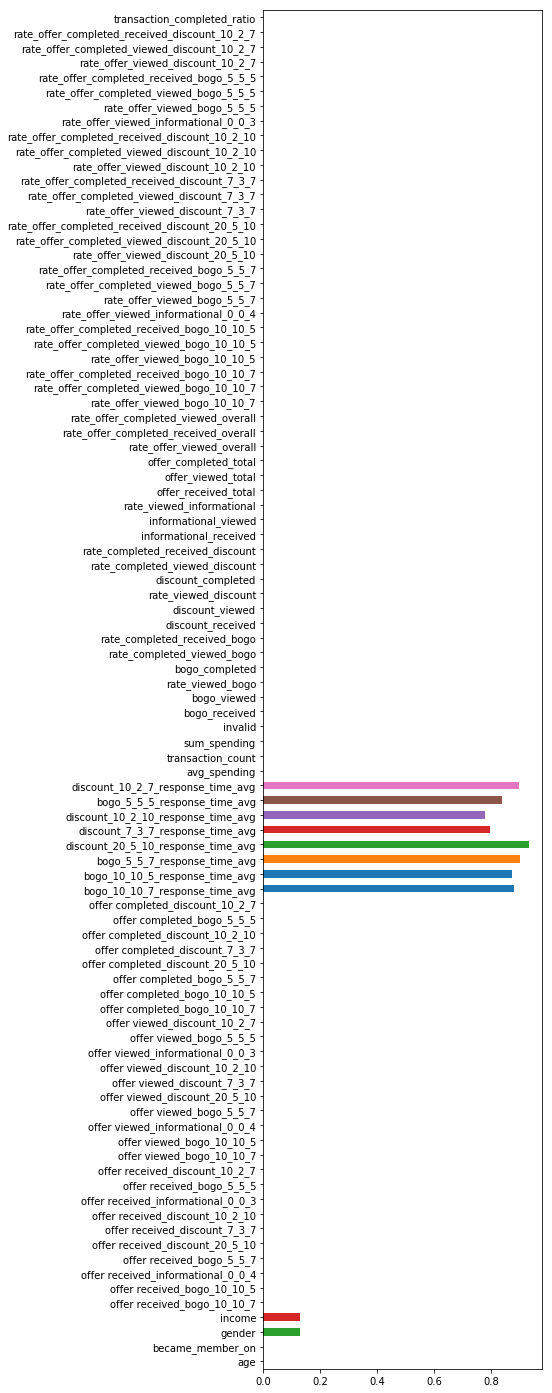

In [14]:
col_null = profile_updated.isnull().sum()
col_null_frac = col_null / profile_updated.shape[0]

plt.figure(figsize= (5,25))
col_null_frac.plot(kind='barh')


In [15]:
# cols to drop that have more than 50% missing values
cols_to_drop = col_null_frac[col_null_frac > 0.5].index.tolist()
cols_to_drop

['bogo_10_10_7_response_time_avg',
 'bogo_10_10_5_response_time_avg',
 'bogo_5_5_7_response_time_avg',
 'discount_20_5_10_response_time_avg',
 'discount_7_3_7_response_time_avg',
 'discount_10_2_10_response_time_avg',
 'bogo_5_5_5_response_time_avg',
 'discount_10_2_7_response_time_avg']

In [16]:
profile_updated_ = profile_updated.drop(cols_to_drop, axis=1)

### 5.2 Assess missing data in rows

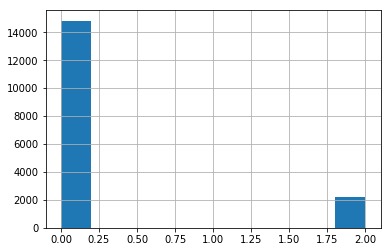

In [17]:
# How much data is missing in each row of the dataset?

row_null = profile_updated_.isnull().sum(axis=1)
row_null.hist()

In [195]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# def dist_compare(attribute, data):
#     row_null = data.isnull().sum(axis=1)
#     f, (ax1,ax2) = plt.subplots(1,2)
#     ax1 = sns.countplot(attribute, data=data[row_null==0], ax=ax1)
#     ax2 = sns.countplot(attribute, data=data[row_null > 0], ax=ax2)
#     ax1.set_title('No missing value')
#     ax2.set_title('With missing value')
#     f.suptitle('Feature: ' + attribute)
#     f.tight_layout()
#     f.subplots_adjust(top=0.8)

def dist_compare_cont(attribute, data):
    row_null = data.isnull().sum(axis=1)
    f, (ax1,ax2) = plt.subplots(1,2, sharex=True)
    ax1 = data[row_null==0][attribute].hist(ax=ax1, bins=20)
    ax2 = data[row_null > 0][attribute].hist( ax=ax2, bins=20)
    ax1.set_title('No missing value')
    ax2.set_title('With missing value')
    f.suptitle('Feature: ' + attribute)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


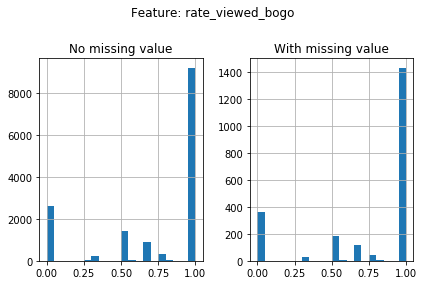

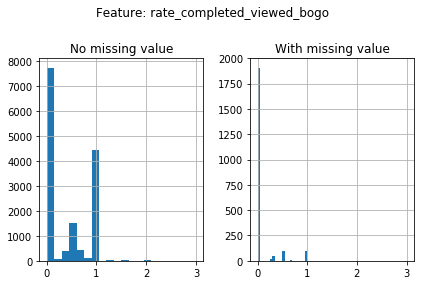

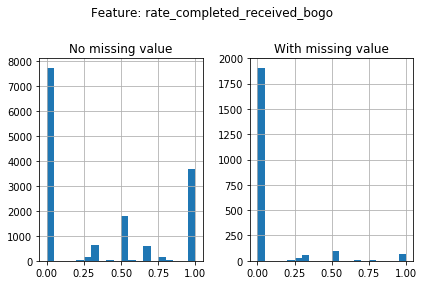

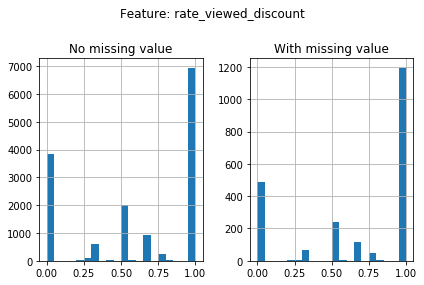

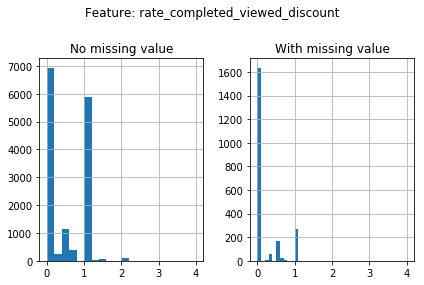

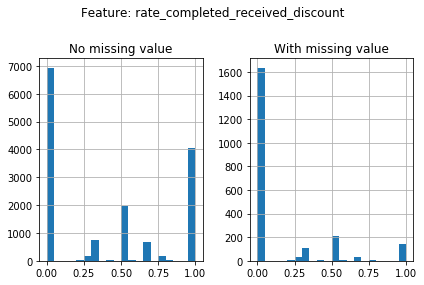

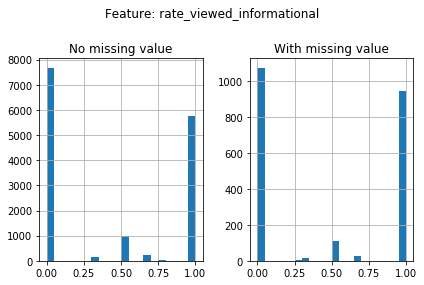

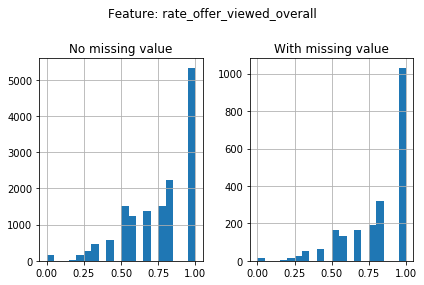

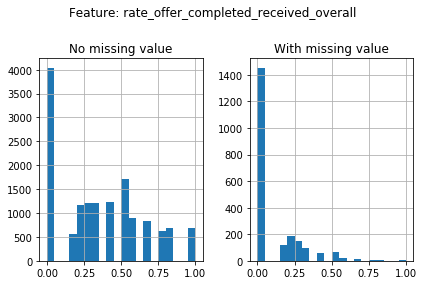

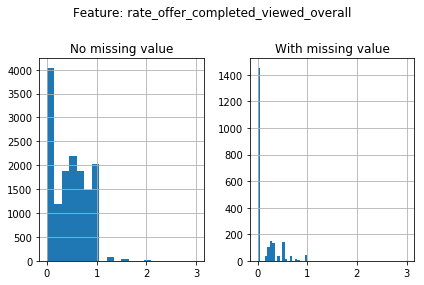

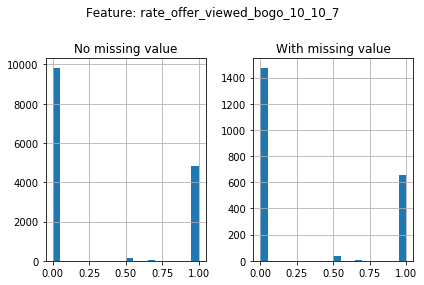

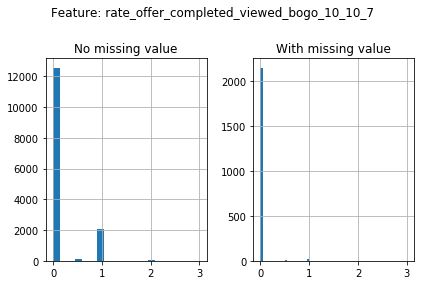

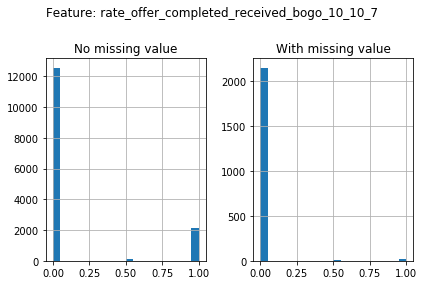

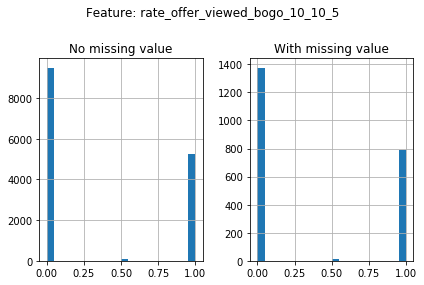

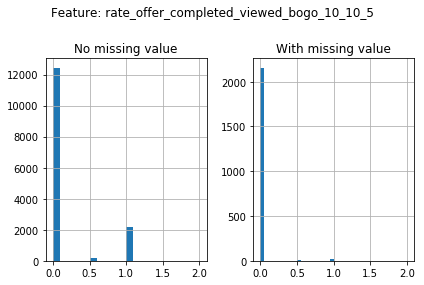

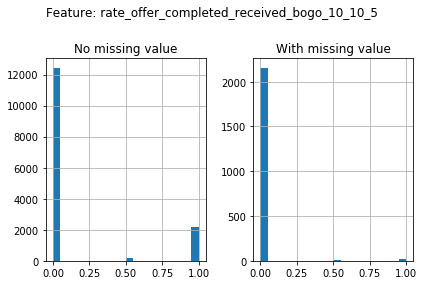

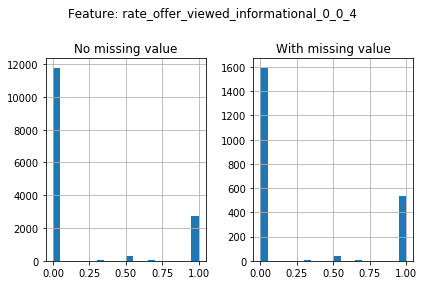

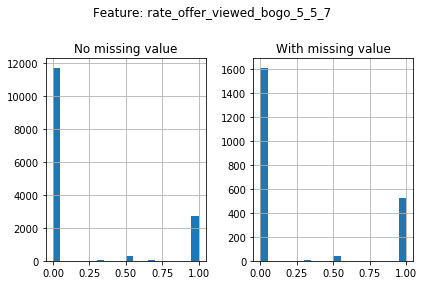

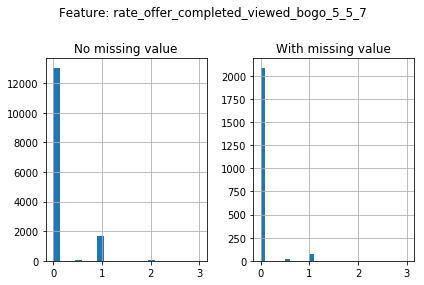

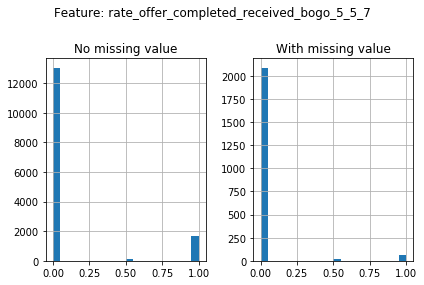

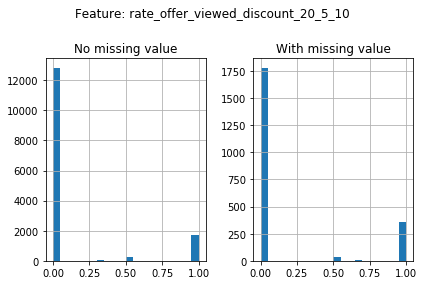

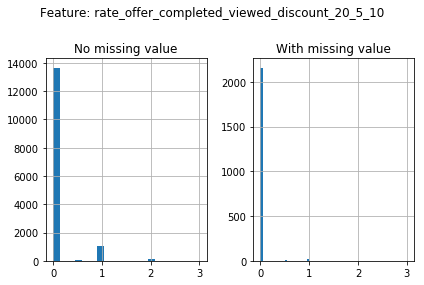

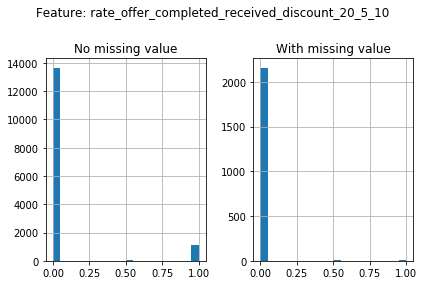

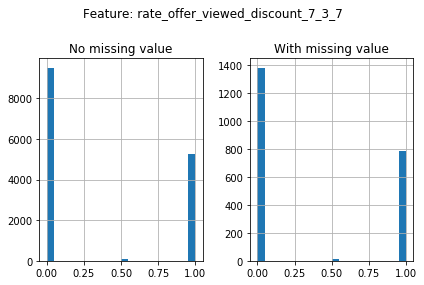

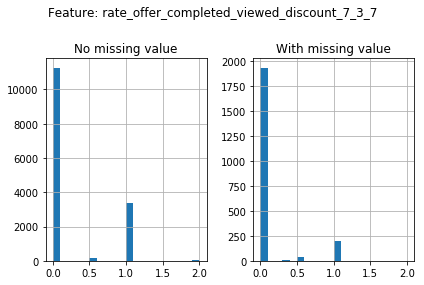

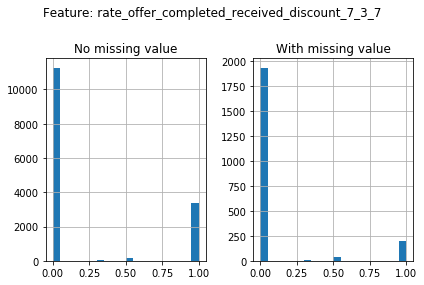

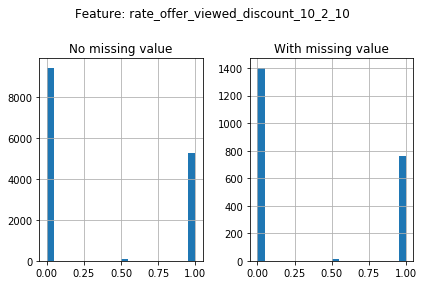

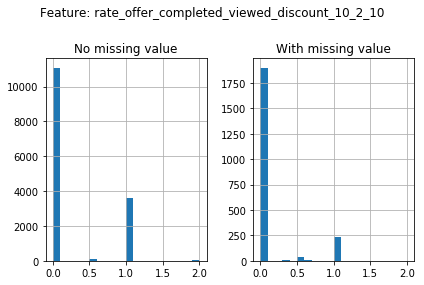

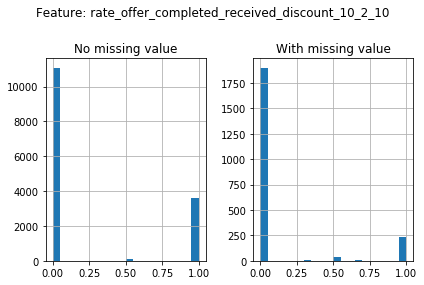

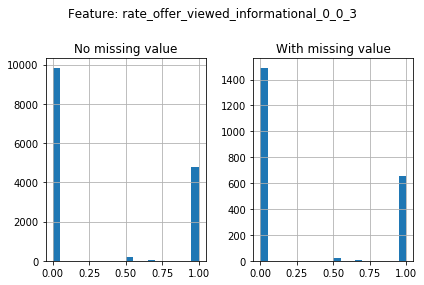

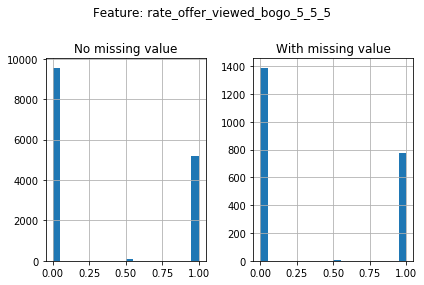

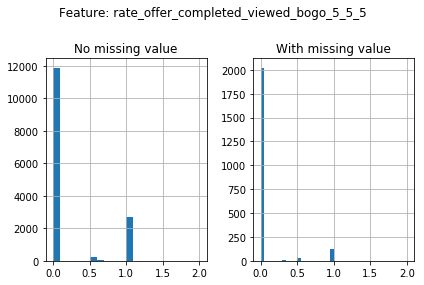

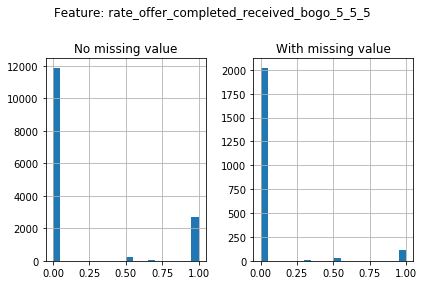

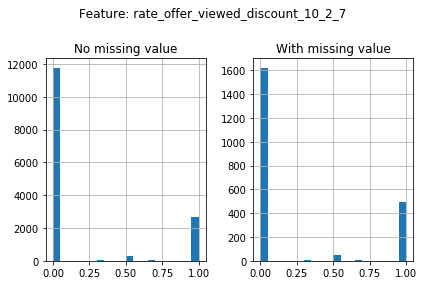

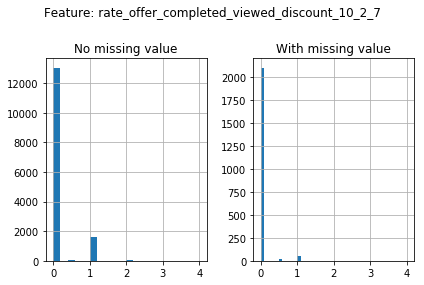

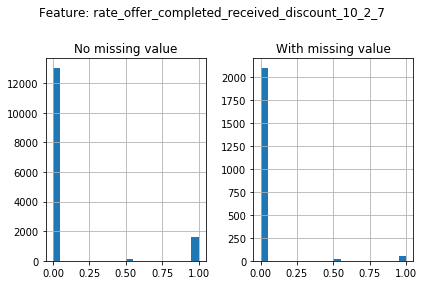

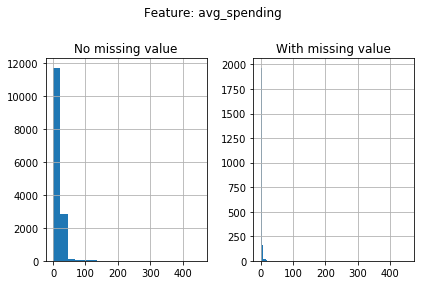

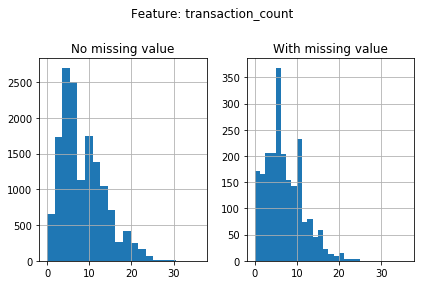

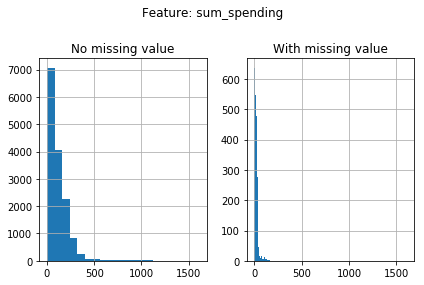

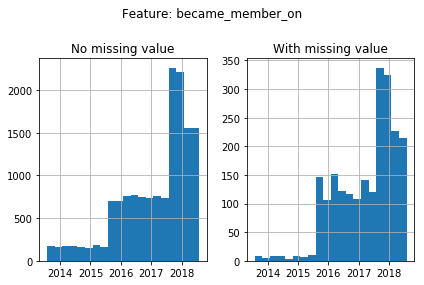

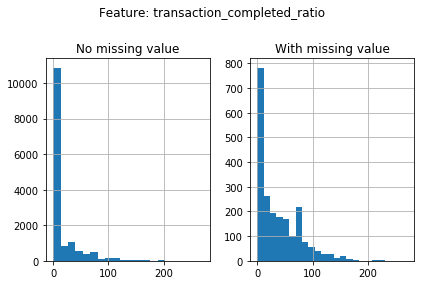

In [240]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

cols_to_compare = profile_updated.columns[profile_updated.columns.str.contains('rate')].tolist() + \
                    [ 'avg_spending', 'transaction_count', 'sum_spending', 'became_member_on', \
                     'transaction_completed_ratio']

for col in cols_to_compare:
    dist_compare_cont(col, profile_updated_)

In [241]:
age = profile_updated[profile_updated.age < 100]
age_100 = profile_updated[profile_updated.age > 100]

In [22]:
df_dummy = profile_updated.copy()
df_dummy.loc[df_dummy.age < 100,'missing_val'] = 'no'
df_dummy.loc[profile_updated.age > 100,'missing_val'] = 'yes'


C:\Users\user\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


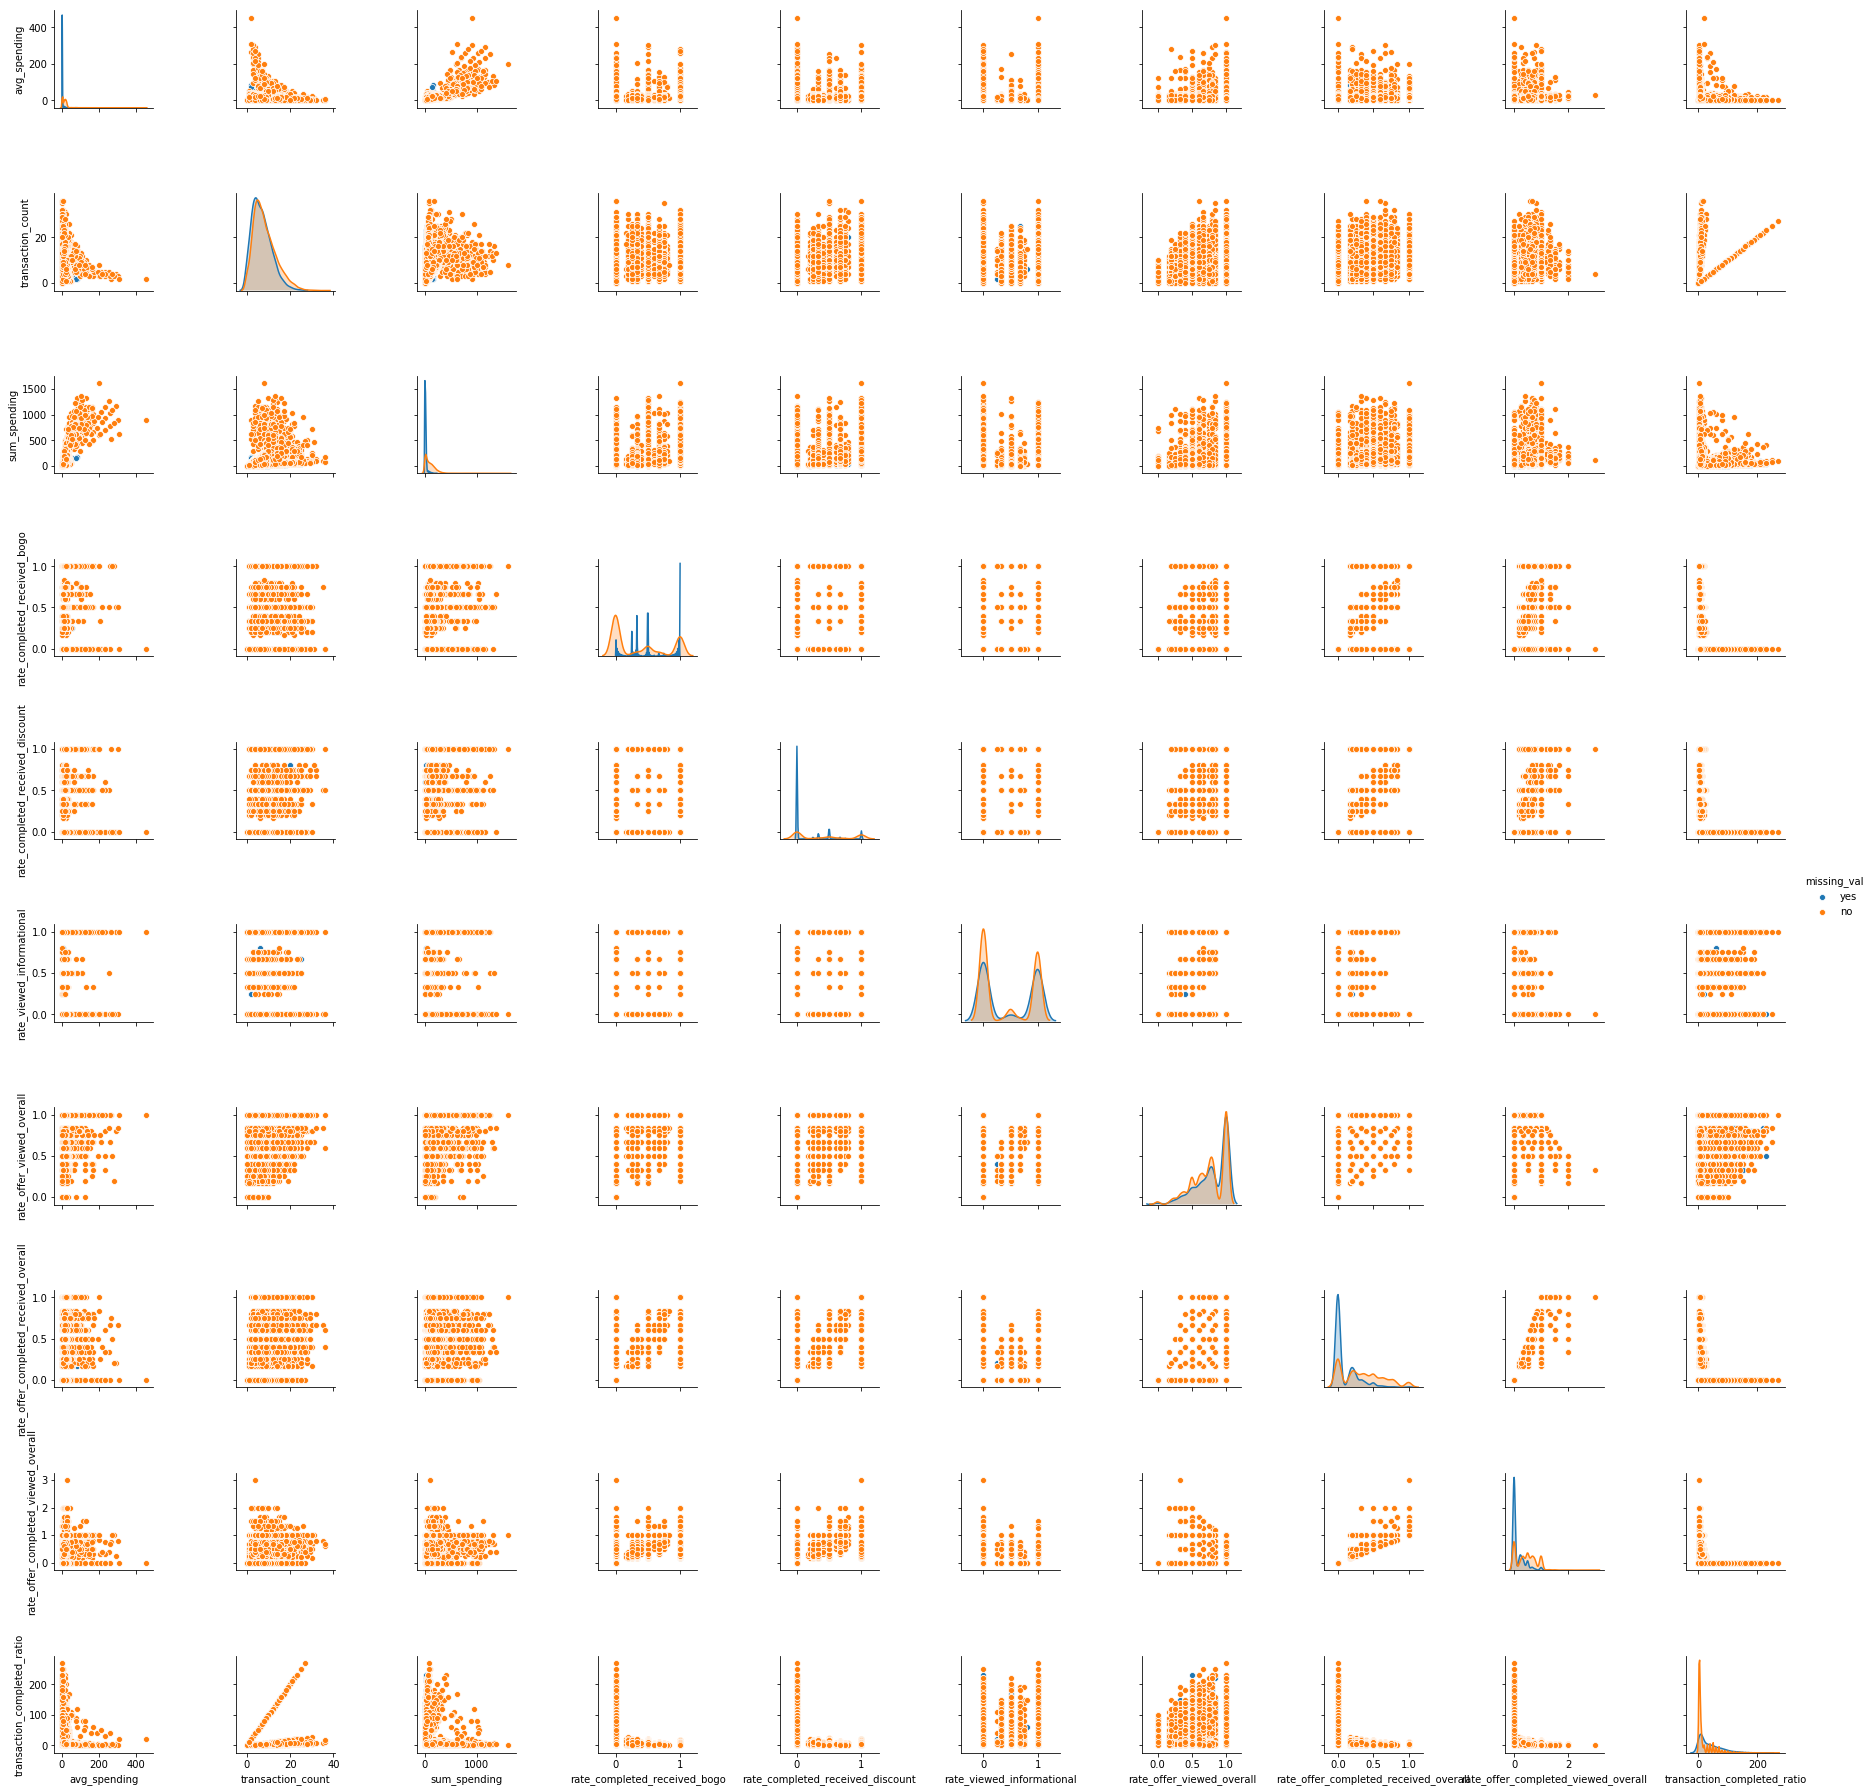

In [23]:
cols = ['avg_spending',
 'transaction_count',
 'sum_spending',
#   'invalid',
 'rate_completed_received_bogo',
 'rate_completed_received_discount',
 'rate_viewed_informational',
 'rate_offer_viewed_overall',
 'rate_offer_completed_received_overall',
 'rate_offer_completed_viewed_overall',
  'transaction_completed_ratio', 'missing_val']


sns.pairplot(df_dummy[cols], hue='missing_val')

The distribution between row data with no missing value and missing value are not similar for all feature, so we will keep both by separating the dataset while performing clustering

In [24]:
# sparate data with age < 100 and age >= 100, missing value on gender and income

#main profile
profile_updated_main = profile_updated_[profile_updated_.age < 100]

#special profile
profile_updated_sp = profile_updated_[profile_updated_.age >= 100]
profile_updated_sp = profile_updated_sp.drop(['gender', 'income', 'age'], axis=1)


### 5.3. Assess profile with valid and invalid offer completed transcript
```
Profile_valid = people who was influenced by offering (value=0)
Profile_invalid = people who was not influenced by offering (value > 0, which means how many transactions they made as invalid offer completed without viewed the offer)
```

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


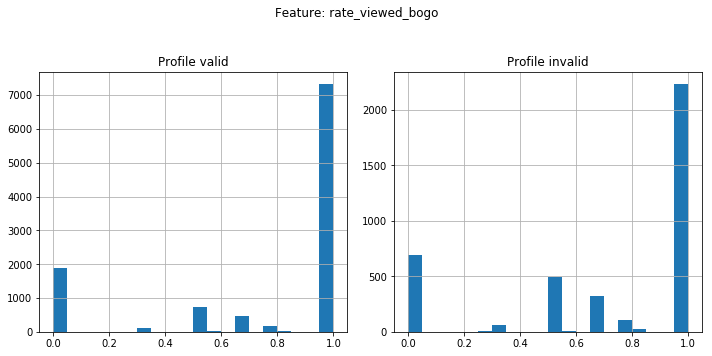

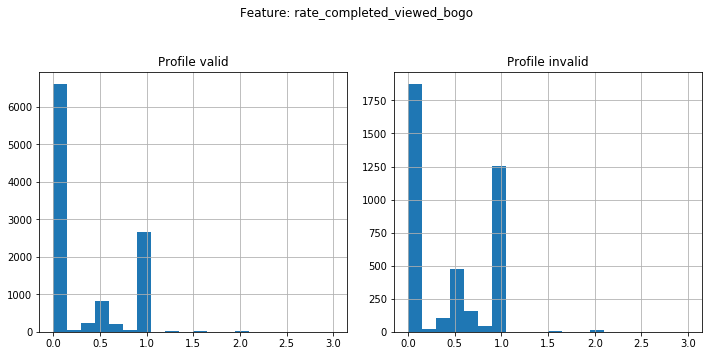

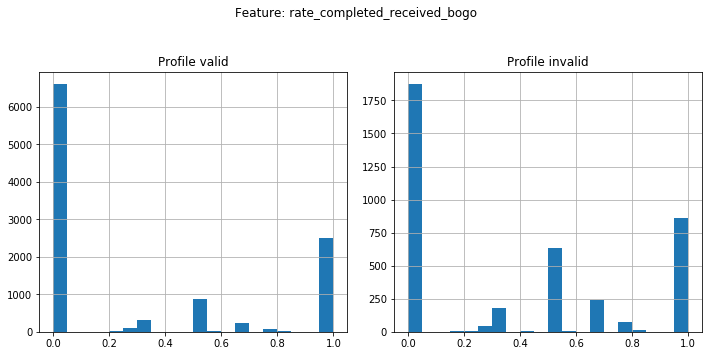

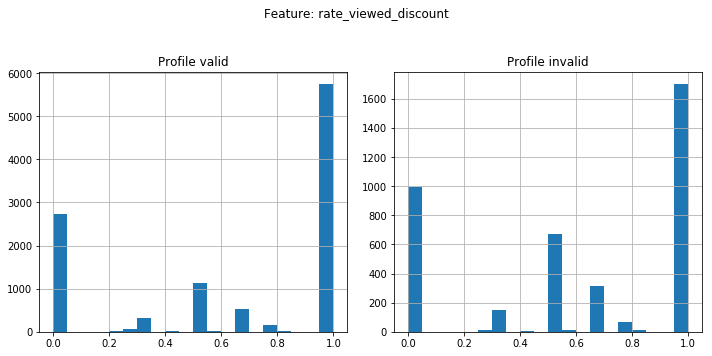

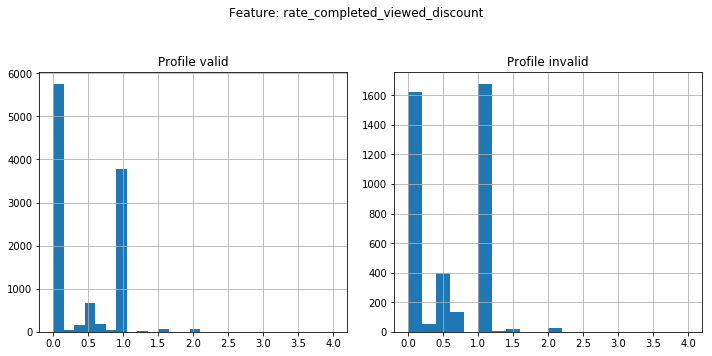

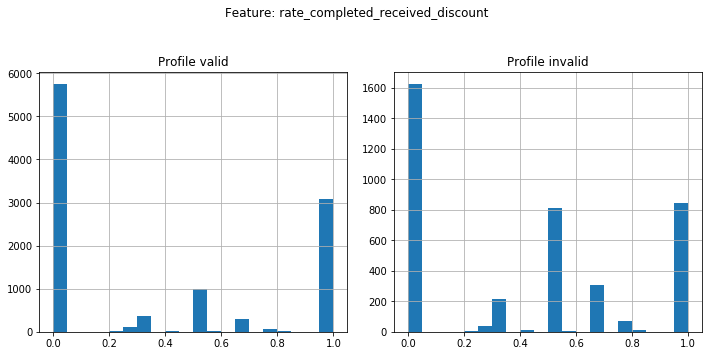

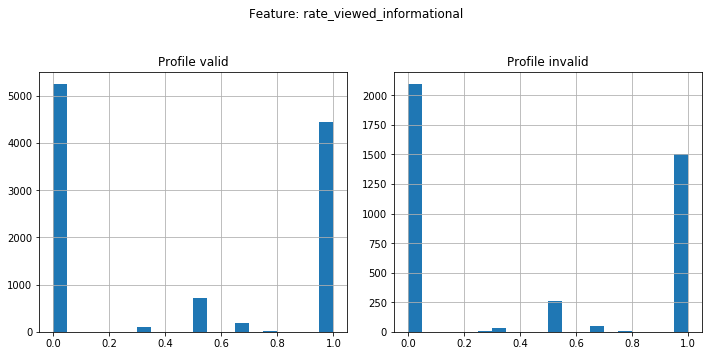

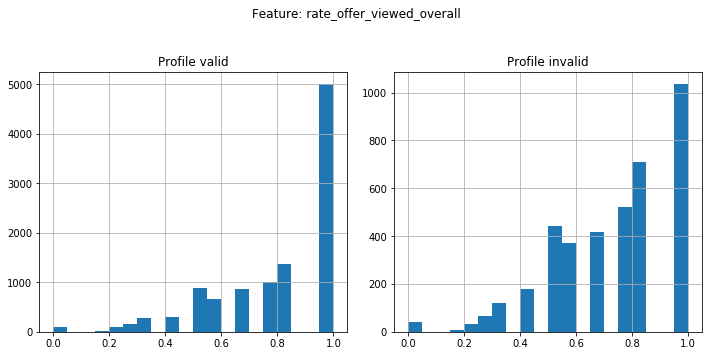

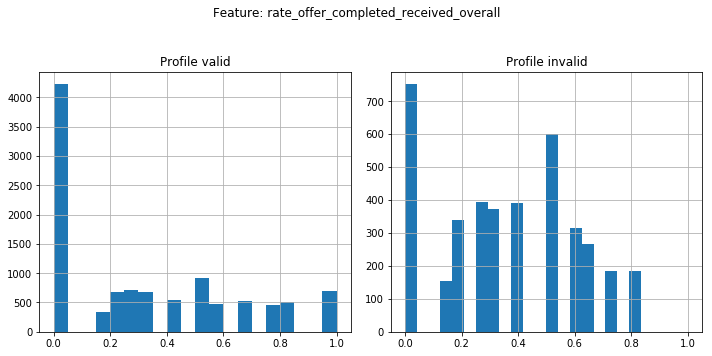

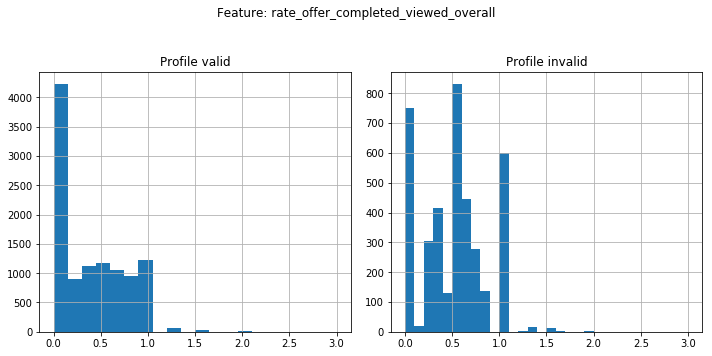

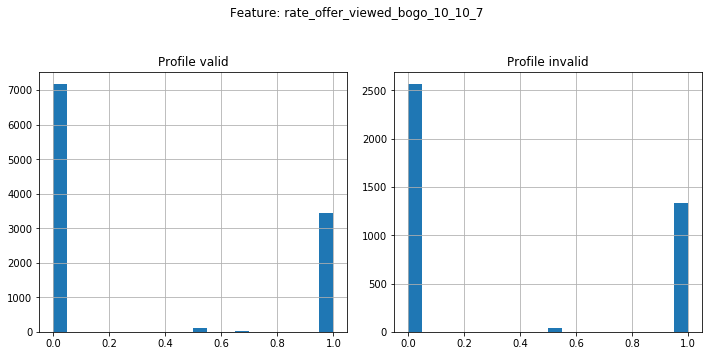

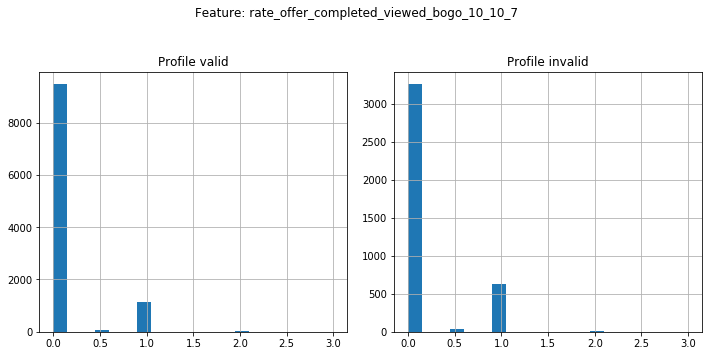

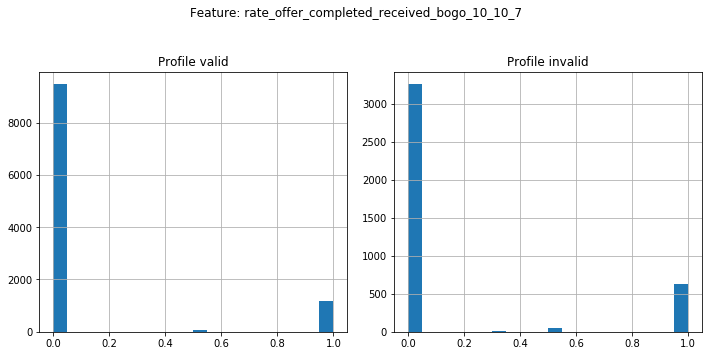

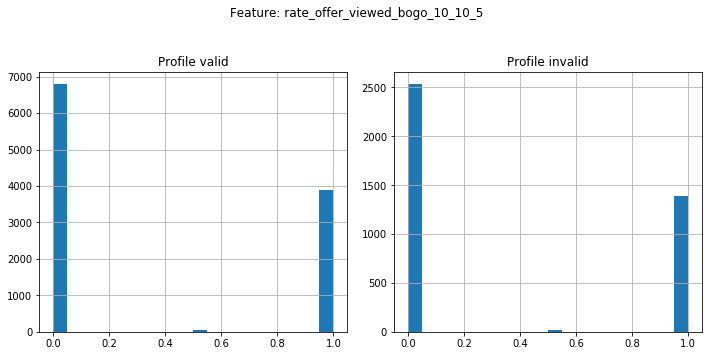

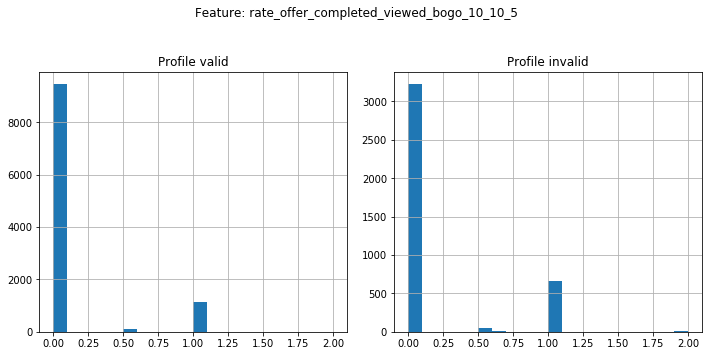

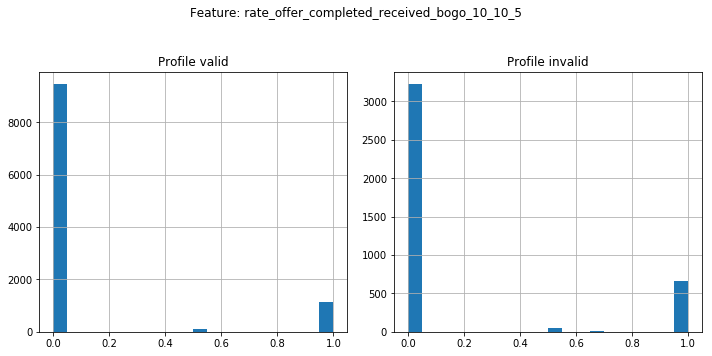

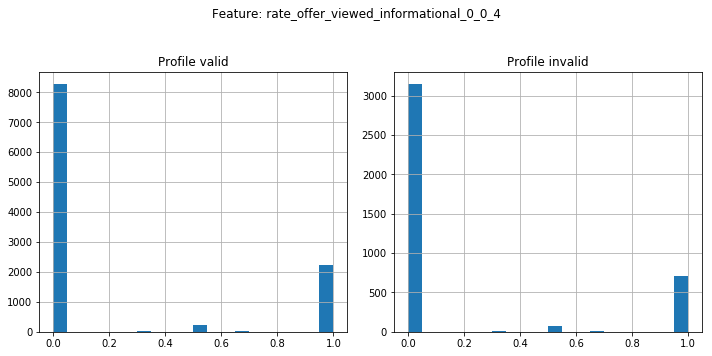

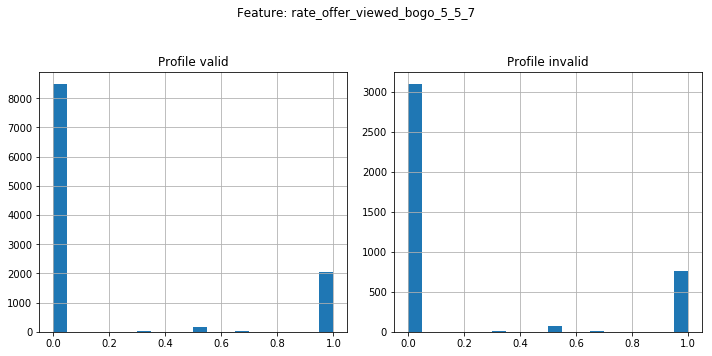

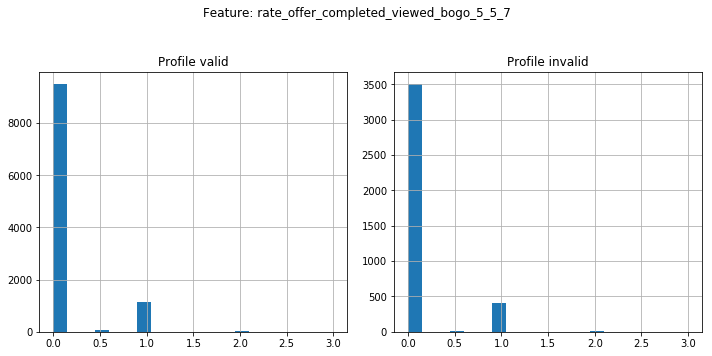

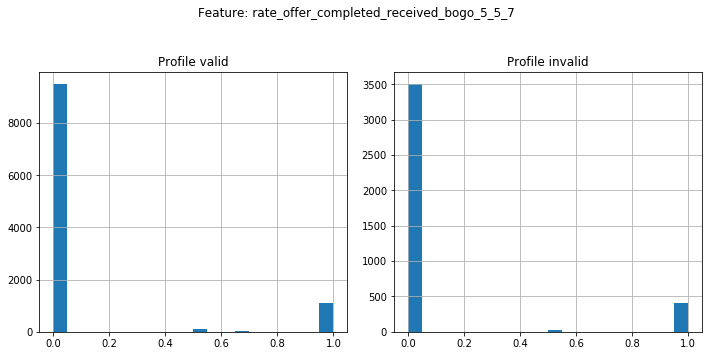

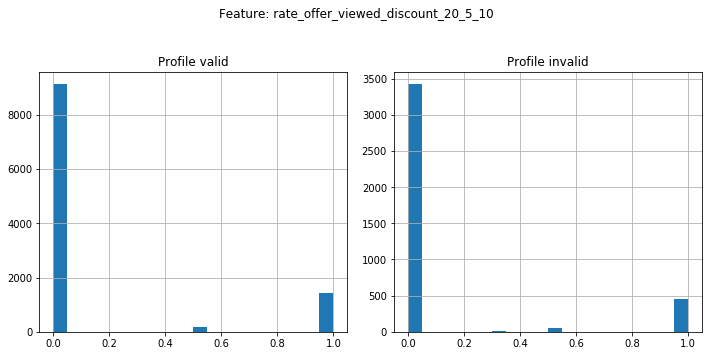

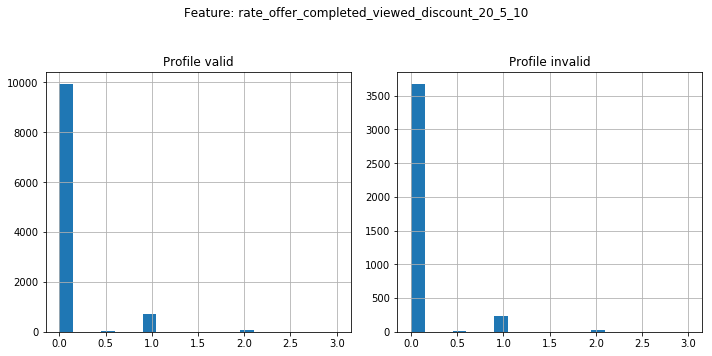

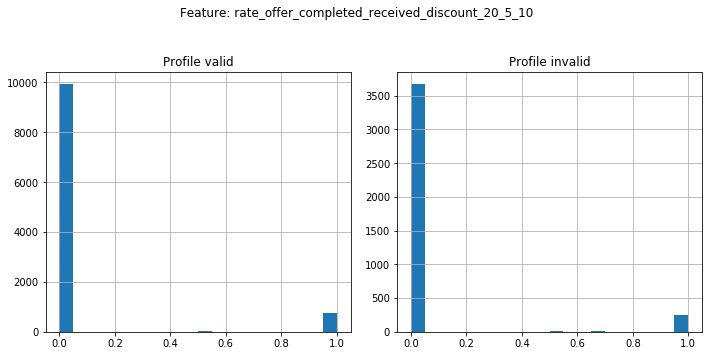

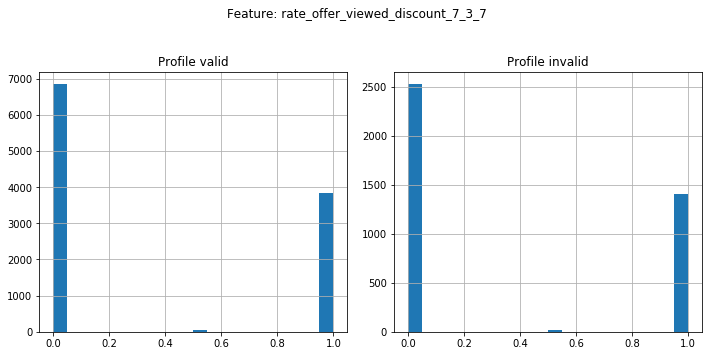

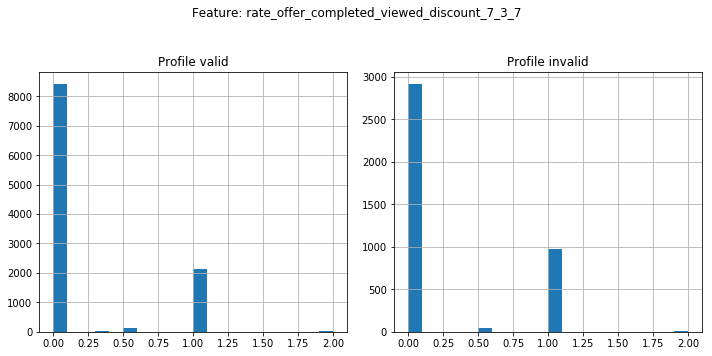

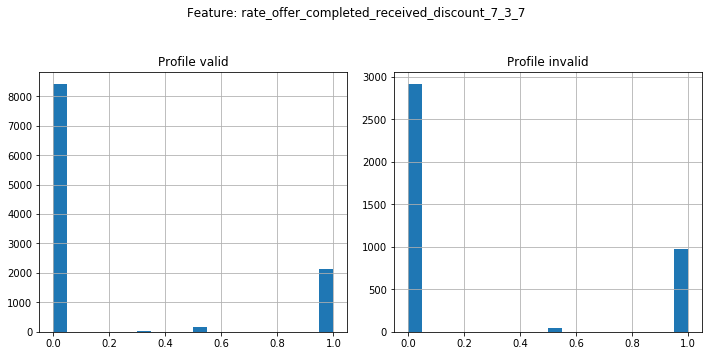

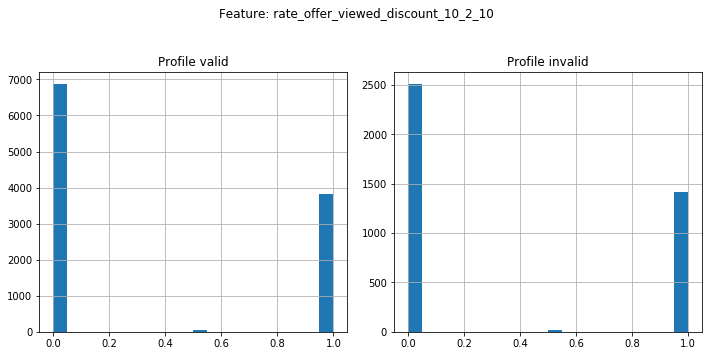

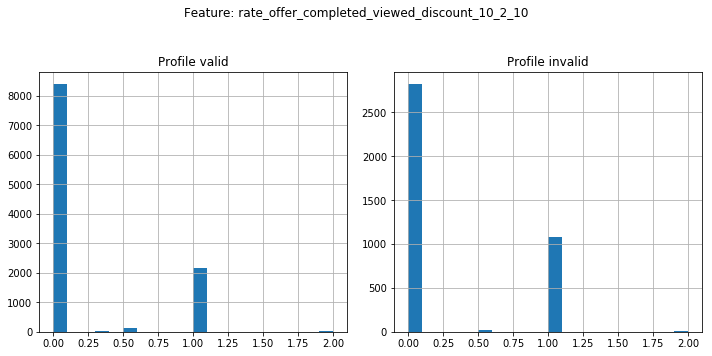

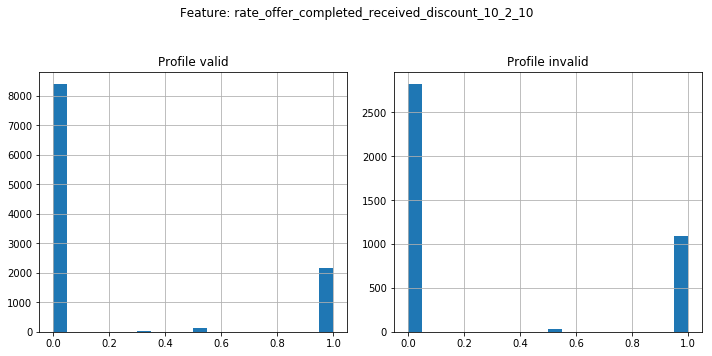

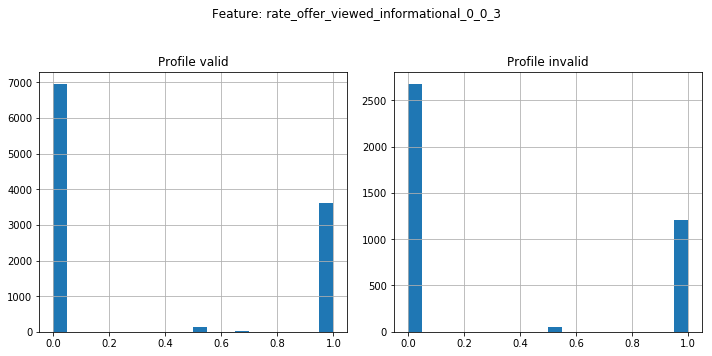

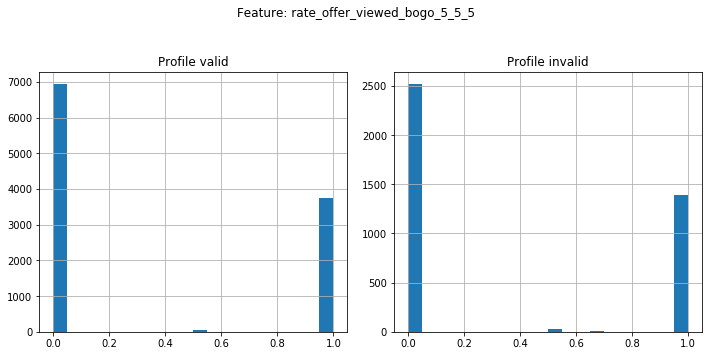

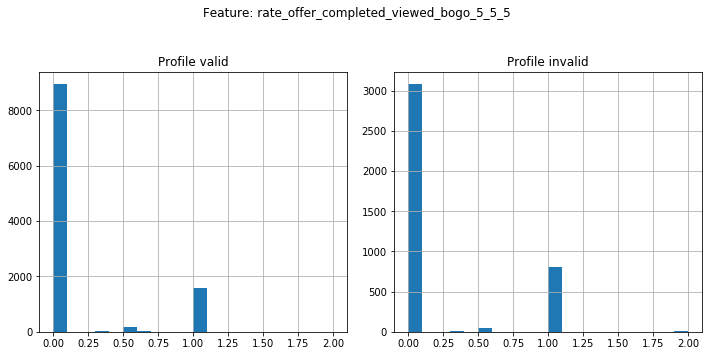

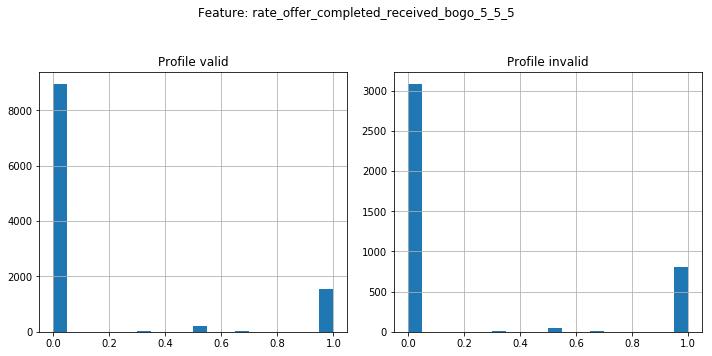

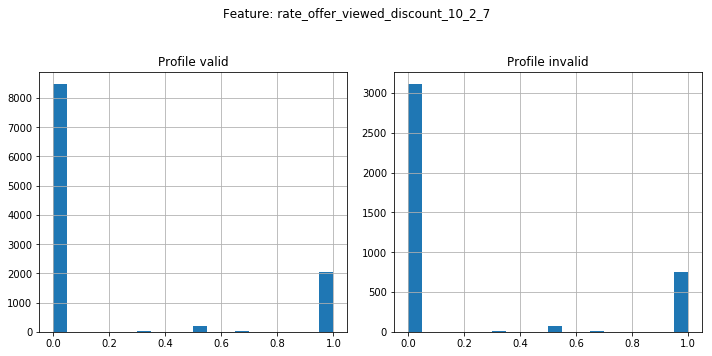

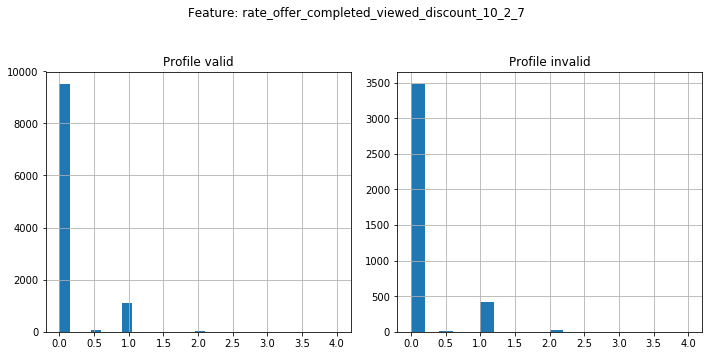

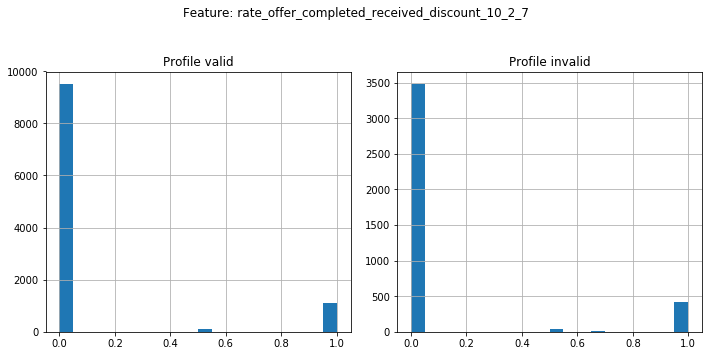

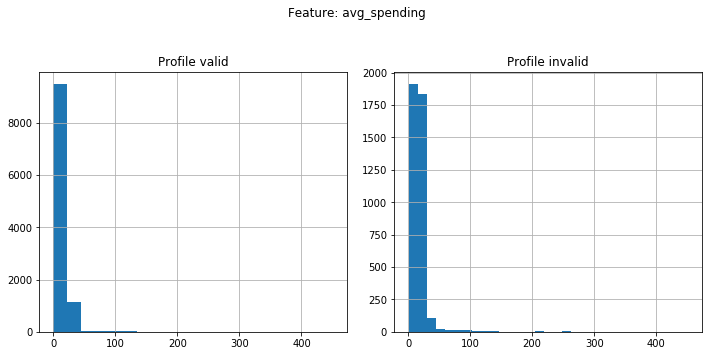

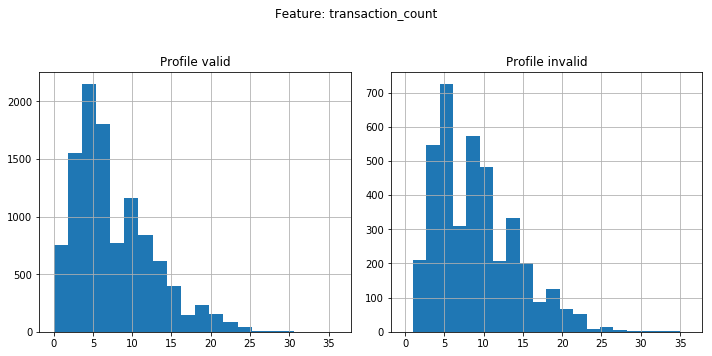

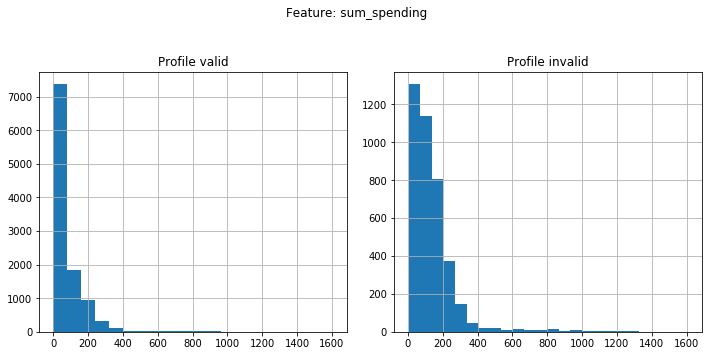

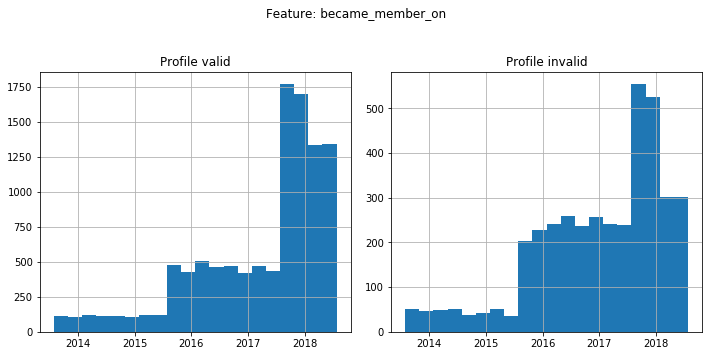

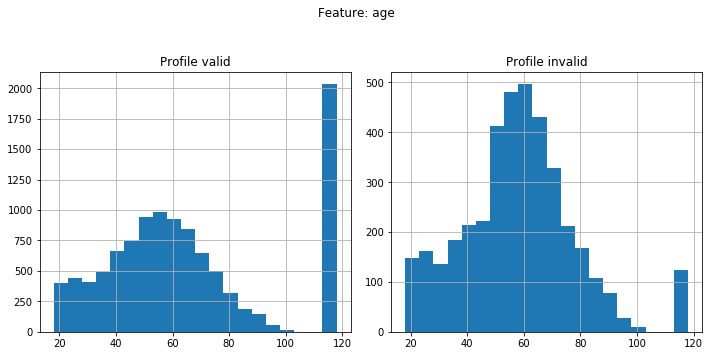

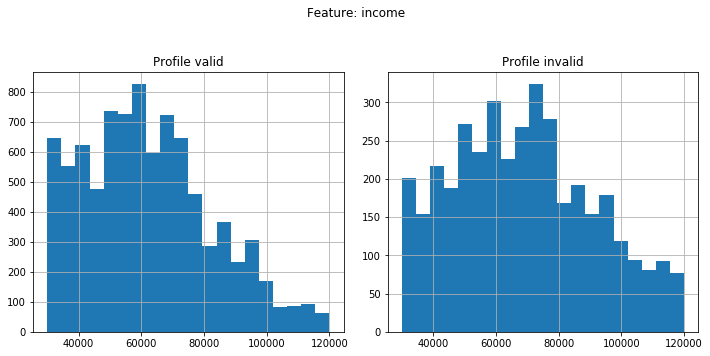

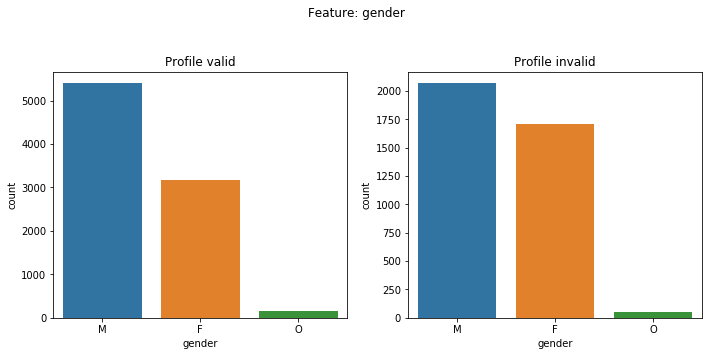

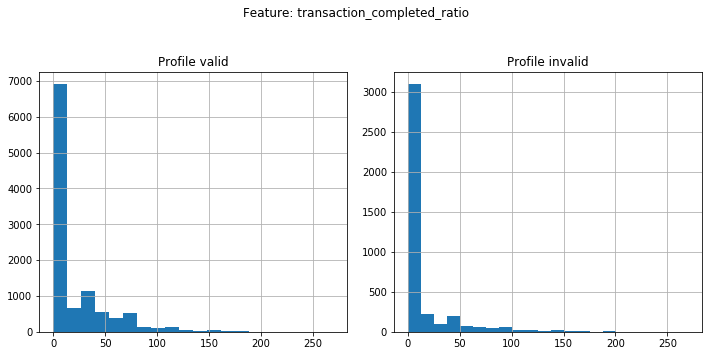

In [27]:
profile_invalid = profile_updated[profile_updated.invalid == 1 ]
profile_valid = profile_updated[profile_updated.invalid == 0]

cols_to_compare = profile_updated.columns[profile_updated.columns.str.contains('rate')].tolist() + \
                    [ 'avg_spending', 'transaction_count', 'sum_spending', 'became_member_on', 'age', 'income','gender',\
                     'transaction_completed_ratio']

for col in cols_to_compare:
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True)
    if col == 'gender':
        ax1 = sns.countplot(col, data=profile_valid, ax=ax1, order=['M','F', 'O'])
        ax2 = sns.countplot(col, data=profile_invalid, ax=ax2, order=['M','F', 'O'])
    else:
        ax1 = profile_valid[col].hist(ax=ax1, bins=20)
        ax2 = profile_invalid[col].hist( ax=ax2, bins=20)
    ax1.set_title('Profile valid')
    ax2.set_title('Profile invalid')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

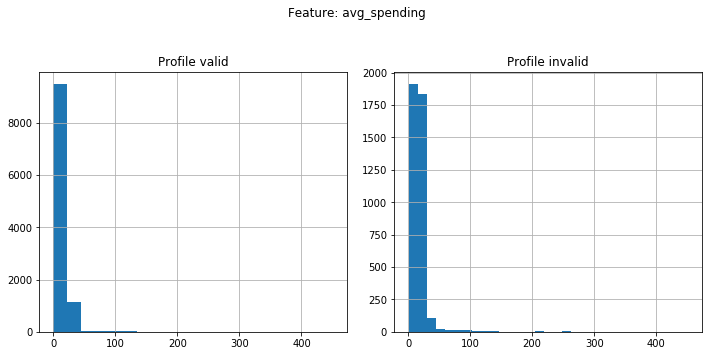

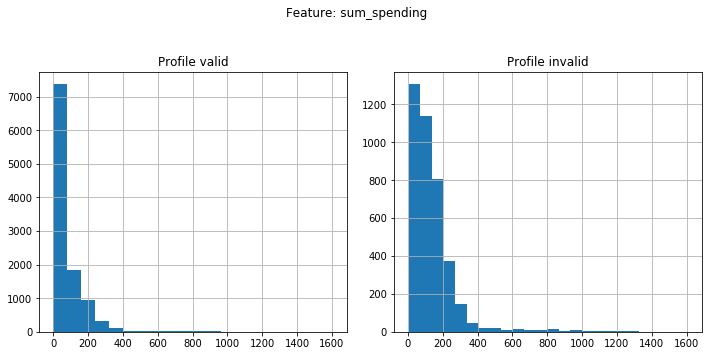

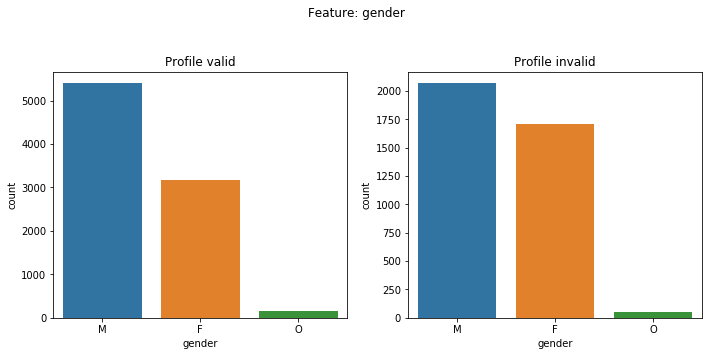

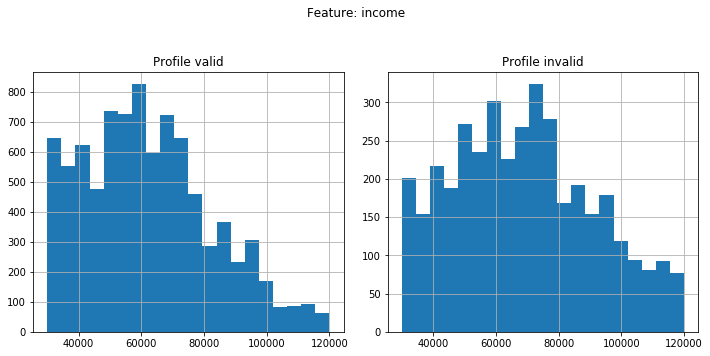

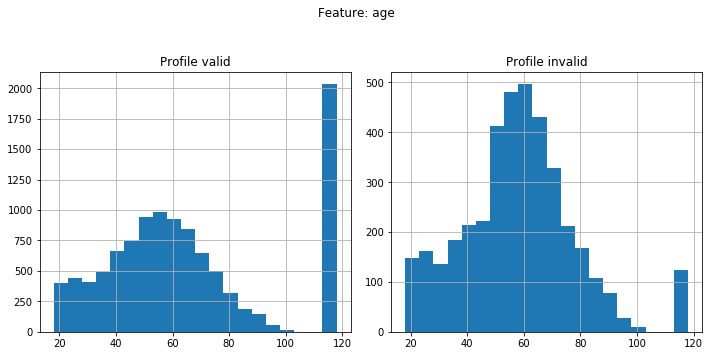

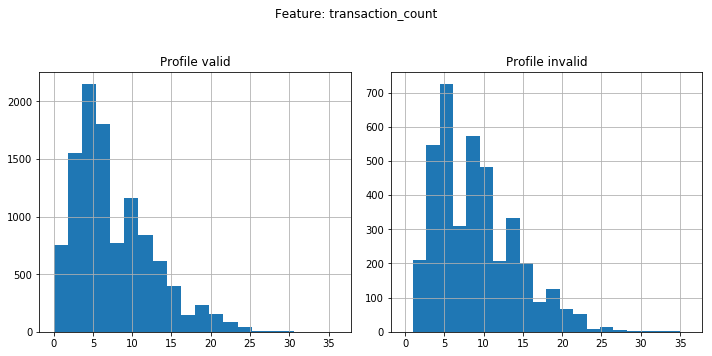

In [29]:
cols_to_compare = [ 'avg_spending','sum_spending', 'gender','income', 'age', 'transaction_count']

for col in cols_to_compare:
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharex=True)
    if col == 'gender':
        ax1 = sns.countplot(col, data=profile_valid, ax=ax1, order=['M','F', 'O'])
        ax2 = sns.countplot(col, data=profile_invalid, ax=ax2, order=['M','F', 'O'])
    else:
        ax1 = profile_valid[col].hist(ax=ax1, bins=20)
        ax2 = profile_invalid[col].hist( ax=ax2, bins=20)
    ax1.set_title('Profile valid')
    ax2.set_title('Profile invalid')
    f.suptitle('Feature: ' + col)
    f.tight_layout()
    f.subplots_adjust(top=0.8)

Profile invalid profiles :
    - Gender : Male & Female is balance, the proportion of female is larger than profile_valid
    - Spending : generally more spending than profile_valid
    - Income : generally higher income than profile_valid

`profile_valid` will be kept as feature for machine learning

 ### 5.4 Re-Encode became_member_on features

In [30]:
import datetime

for df in [profile_updated_main, profile_updated_sp]:
    df.loc[:,'member_days_since'] = (datetime.datetime(2018,12,31) - df.became_member_on).dt.days 
    df.loc[:,'member_year'] = df.became_member_on.dt.year.astype(str)

profile_updated_main = profile_updated_main.drop('became_member_on', axis=1)
profile_updated_sp = profile_updated_sp.drop('became_member_on', axis=1)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
profile_updated_main.head()

age gender    income  \
Unnamed: 0                                               
0610b486422d4921ae7d2bf64640c50b   55      F  112000.0   
78afa995795e4d85b5d9ceeca43f5fef   75      F  100000.0   
e2127556f4f64592b11af22de27a7932   68      M   70000.0   
389bc3fa690240e798340f5a15918d5c   65      M   53000.0   
2eeac8d8feae4a8cad5a6af0499a211d   58      M   51000.0   

                                  offer received_bogo_10_10_7  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          1.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 1.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
e2127556f4f64592b11af22de27a7932                                 1.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
0610b486422d4921ae7d2bf64640c50b                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
e2127556f4f64592b11af22de27a7932                        1.0   
389bc3fa690240e798340f5a15918d5c                        2.0   
2eeac8d8feae4a8cad5a6af0499a211d                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              0.0   
389bc3fa690240e798340f5a15918d5c                              0.0   
2eeac8d8feae4a8cad5a6af0499a211d                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
0610b486422d4921ae7d2bf64640c50b                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
e2127556f4f64592b11af22de27a7932                            0.0   
389bc3fa690240e798340f5a15918d5c                            0.0   
2eeac8d8feae4a8cad5a6af0499a211d                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              1.0   
389bc3fa690240e798340f5a15918d5c                              1.0   
2eeac8d8feae4a8cad5a6af0499a211d                              1.0   

                                     ...       \
Unnamed: 0                           ...        
0610b486422d4921ae7d2bf64640c50b     ...        
78afa995795e4d85b5d9ceeca43f5fef     ...        
e2127556f4f64592b11af22de27a7932     ...        
389bc3fa690240e798340f5a15918d5c     ...        
2eeac8d8feae4a8cad5a6af0499a211d    

In [53]:
profile_updated_sp.head()

offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          0.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          1.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 1.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                        0.0   
68617ca6246f4fbc85e91a2a49552598                        1.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              0.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                            0.0   
68617ca6246f4fbc85e91a2a49552598                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              2.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              2.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_informational_0_0_3  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 1.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 0.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_5  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5           

 ### 5.5 Re-Encode Categorical Features

In [31]:
# one hot gender columns

profile_onehot_main = pd.get_dummies(profile_updated_main)

profile_onehot_sp = pd.get_dummies(profile_updated_sp)


### 5.6 Create a feature preprocessing function

In [3]:
import datetime

def add_invalid_feature(profile_updated_df, transcript_merge_df):
    profile_updated_df = profile_updated_df.copy()
    
    person_invalid = transcript_merge_df[transcript_merge_df.invalid == 1].person.value_counts()
    # create new feature 'invalid', how many invalid transaction made by customer (transaction that not influenced by offer)
    profile_updated_df['invalid'] = person_invalid
    profile_updated_df['invalid'] = profile_updated_df['invalid'].fillna(0)
    
    return profile_updated_df

def add_feature_rate_portfolio_type(profile_updated_df):
    """ 
    Create features
        - Total Count of the offer received, reviewed, completed for each type of portfolio (bogo, discount, and informational)
        - Rates for each offering type (bogo/discount/informational) : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received

    """
    profile_updated = profile_updated_df.copy()

    for offer in ['bogo', 'discount', 'informational']:
        received_cols = profile_updated.columns[(profile_updated.columns.str.contains('received_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate' ))].tolist()
        profile_updated[offer +'_received'] = profile_updated[received_cols].sum(axis=1).fillna(0)

        viewed_cols = profile_updated.columns[(profile_updated.columns.str.contains('viewed_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate'))].tolist()
        profile_updated[offer +'_viewed'] = profile_updated[viewed_cols].sum(axis=1).fillna(0)

        profile_updated['rate_viewed_' + offer] = (profile_updated[offer +'_viewed'] / profile_updated[offer +'_received']).fillna(0)

        if offer != 'informational':
            completed_cols = profile_updated.columns[(profile_updated.columns.str.contains('completed_' + offer)) & \
                                                (~profile_updated.columns.str.contains('rate' ))].tolist()
            profile_updated[offer +'_completed'] = profile_updated[completed_cols].sum(axis=1).fillna(0)

            profile_updated['rate_completed_viewed_' + offer] = \
                        (profile_updated[offer +'_completed'] /profile_updated[offer +'_viewed']).fillna(0)
            profile_updated['rate_completed_received_' + offer] = \
                        (profile_updated[offer +'_completed'] / profile_updated[offer +'_received']).fillna(0)

    return profile_updated

def add_feature_rate_overall(profile_updated_df):

    """ 
    Create Feature :
    - Total count of received, viewed, completed
    - Overall Rates : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received

    """
    profile_updated = profile_updated_df.copy()
    
    profile_updated['offer_received_total'] = profile_updated.bogo_received + profile_updated.discount_received + \
                                            profile_updated.informational_received

    profile_updated['offer_viewed_total'] = profile_updated.bogo_viewed + profile_updated.discount_viewed + \
                                            profile_updated.informational_viewed

    profile_updated['offer_completed_total'] = profile_updated.bogo_completed + profile_updated.discount_completed 

    profile_updated['rate_offer_viewed_overall'] = \
            (profile_updated['offer_viewed_total'] / profile_updated['offer_received_total']).fillna(0)

    profile_updated['rate_offer_completed_received_overall'] = \
            (profile_updated['offer_completed_total'] / profile_updated['offer_received_total']).fillna(0)

    profile_updated['rate_offer_completed_viewed_overall'] = \
            (profile_updated['offer_completed_total'] / profile_updated['offer_viewed_total']).fillna(0)


    return profile_updated


def add_feature_rate_portfolio_id(profile_updated_df, portfolio_df):
    
    """
    Create Feature :
    - Rates for each offering in portfolio  : 
            - rate_review = total reviewed / total received
            - rate_completed_reviewed = total completed / total reviewed
            - rate_completed_received = tatal completed / total received
    """
    profile_updated = profile_updated_df.copy()
    portfolio_updated = h.portfolio_preprocessing(portfolio_df)

    for offer_name in portfolio_updated.name.tolist():
        profile_updated['rate_offer_viewed_' + offer_name ] = \
            (profile_updated['offer viewed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)

        if offer_name not in portfolio_updated[portfolio_updated.name.str.contains('informational')]['name'].tolist() :
            profile_updated['rate_offer_completed_viewed_' + offer_name ] = \
                (profile_updated['offer completed_' + offer_name] / profile_updated['offer viewed_' + offer_name]).fillna(0)

            profile_updated['rate_offer_completed_received_' + offer_name ] = \
                (profile_updated['offer completed_' + offer_name] / profile_updated['offer received_' + offer_name]).fillna(0)
    
    return profile_updated

def add_feature_transaction_completed_ratio(profile_updated_df):
    """
    Create feature transcation count to offer completed ratio

    to avoid np.inf as a result of division, a 0.1 number was added to the denominator 
    """
    profile_updated = profile_updated_df.copy()

    profile_updated['transaction_completed_ratio'] = \
            profile_updated.transaction_count / (profile_updated.offer_completed_total + 0.1)
    
    return profile_updated


def separate_profile(profile_updated_df):
    # sparate data with age < 100 and age >= 100, missing value on gender and income

    #main profile
    profile_updated_main = profile_updated_df[profile_updated_df.age < 100]

    #special profile
    profile_updated_sp = profile_updated_df[profile_updated_df.age >= 100]
    profile_updated_sp = profile_updated_sp.drop(['gender', 'income', 'age'], axis=1)
    
    return profile_updated_main, profile_updated_sp


def encode_member_day(profile_updated_df):
    profile_updated_df = profile_updated_df.copy()
    profile_updated_df['member_days_since'] = (datetime.datetime(2018,12,31) - profile_updated_df.became_member_on).dt.days 
    profile_updated_df['member_year'] = profile_updated_df.became_member_on.dt.year.astype(str)
    profile_updated_df = profile_updated_df.drop('became_member_on', axis=1)
    return profile_updated_df

def feature_preprocessing(profile_updated_df, transcript_all_df, portfolio_df):
    # add feature whether the customer made a valid or invalid transaction of offer completed
    profile_updated_df = add_invalid_feature(profile_updated_df, transcript_all_df)
    
    # add feature rate per portfolio type (bogo/discount/informational)
    profile_updated_df = add_feature_rate_portfolio_type(profile_updated_df)
    
    # add feature rate overall by event type (offer received, viewed, completed)
    profile_updated_df = add_feature_rate_overall(profile_updated_df)
    
    # add feature rate for individual portfolio id
    profile_updated_df = add_feature_rate_portfolio_id(profile_updated_df, portfolio_df)
    
    # add feature transaction to offer completed ratio
    profile_updated_df =add_feature_transaction_completed_ratio(profile_updated_df)
    
    #drop features that have more than 50% missing values
    col_null = profile_updated_df.isnull().sum()
    col_null_frac = col_null / profile_updated_df.shape[0]
    cols_to_drop = col_null_frac[col_null_frac > 0.5].index.tolist()
    profile_updated_df = profile_updated_df.drop(cols_to_drop, axis=1)
    
    # remove row data that have age > 100 years, missing values on income and gender
    profile_updated_main, profile_updated_sp = separate_profile(profile_updated_df)
    
    # re-encode became_member_on to member_day (how may days since become member from 31 dec 2018)
    profile_updated_clean = encode_member_day(profile_updated_main)
    profile_updated_sp = encode_member_day(profile_updated_sp)
    
    # one-hot the categorical features
    profile_onehot_main = pd.get_dummies(profile_updated_clean)
    profile_onehot_sp = pd.get_dummies(profile_updated_sp)

    return profile_onehot_main, profile_onehot_sp

In [4]:
profile_dummy = h.feature_extraction(transcript_clean,profile, portfolio)

The profile_updated.csv file is available at local folder.


In [5]:
profile_main, profile_sp = feature_preprocessing(profile_dummy, transcript_all, portfolio)

## 6. Feature Transformation

### 6.1 Feature Scaling

In [172]:
from sklearn.preprocessing import StandardScaler

def perform_scaling(df):
    scaler = StandardScaler()
    std_arr = scaler.fit_transform(df)
    df_std = pd.DataFrame(std_arr, index=df.index, columns= df.columns)
    return df_std, scaler

profile_std_main, scaler_main = perform_scaling(profile_main)
profile_std_sp, scaler_sp = perform_scaling(profile_sp)

In [173]:
h.save(scaler_main, 'scaler_main.sav')
h.save(scaler_sp, 'scaler_sp.sav')

### 6.2. Perform Dimensionality Reduction

In [139]:
from sklearn.decomposition import PCA

pca_main = PCA()
pca_main.fit(profile_std_main)

pca_sp = PCA()
pca_sp.fit(profile_std_sp)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [140]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
#     for i in range(num_components):
#         ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


Number of Main PCA components that explained at least 95% variance : 34


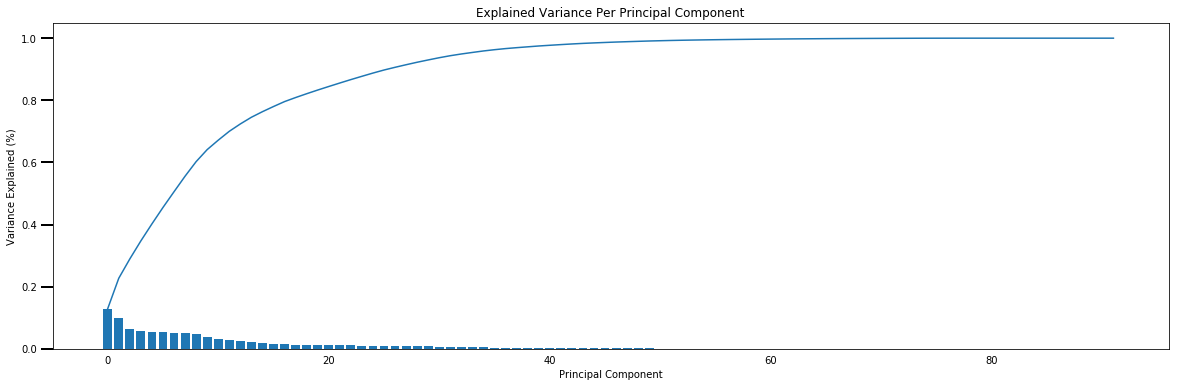

In [141]:
#scree plot for main profile
scree_plot(pca_main)

#PCA
# number of PCA components that explained at least 95% variance ==> 34 components
cumvals = np.cumsum(pca_main.explained_variance_ratio_)
print("Number of Main PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

Number of Special PCA components that explained at least 95% variance : 29


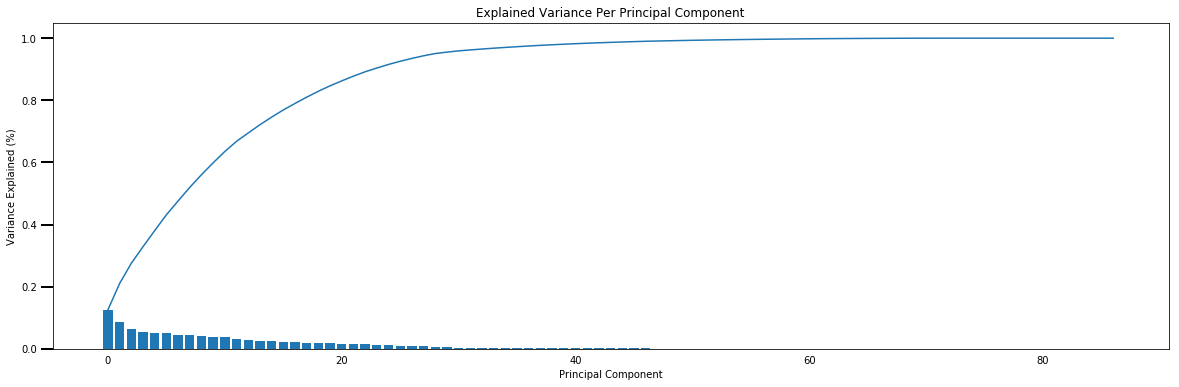

In [142]:
#scree plot for special profile
scree_plot(pca_sp)

#PCA
# number of PCA components that explained at least 95% variance ==> 29 components
cumvals = np.cumsum(pca_sp.explained_variance_ratio_)
print("Number of Special PCA components that explained at least 95% variance : {}".format(np.where(cumvals >= 0.95)[0][0]+1))

In [143]:
#PCA transform with 95% explained variance


def pca_fit_transform(df, var = None):
    pca = PCA(var)
    transform_arr = pca.fit_transform(df)
    return pca, transform_arr

pca_main, pca_transform_main = pca_fit_transform(profile_std_main, var=0.95)
pca_sp, pca_transform_sp = pca_fit_transform(profile_std_sp, var=0.95)

In [171]:
h.save(pca_main, 'pca_main.sav')
h.save(pca_sp, 'pca_sp.sav')



### 6.3 Interpret Principal Components

In [146]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.


def plot_weight(df, pca, ith) :
    '''
    plot weight for the i-th principal component to corresponding feature names
    Input : 
        df = original dataframe
        pca = pca.fit(data)
        ith = int value, from 1 to len(pca.n_components)
    Return : axes of barplot 
    '''
    sort_pca = sorted([(weight, label) for weight,label in zip(pca.components_[ith-1], df.columns) ])
    weights, features = zip(*sort_pca)
    weights, features = list(weights), list(features)
    fig, ax = plt.subplots(figsize=(10,20))
    ax = sns.barplot(weights, features)
    return ax

#### 6.3.1. Main Profile

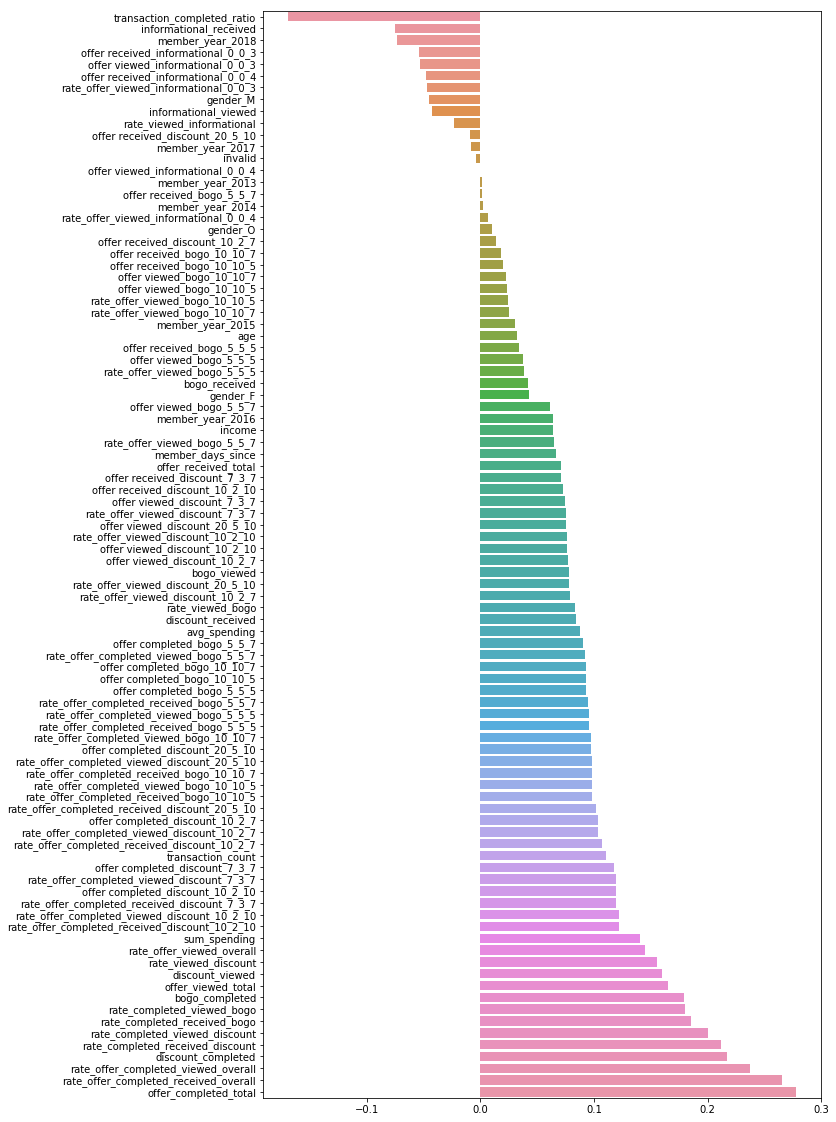

In [147]:
# 1st PCA comp
plot_weight(profile_std_main,pca_main, 1 )

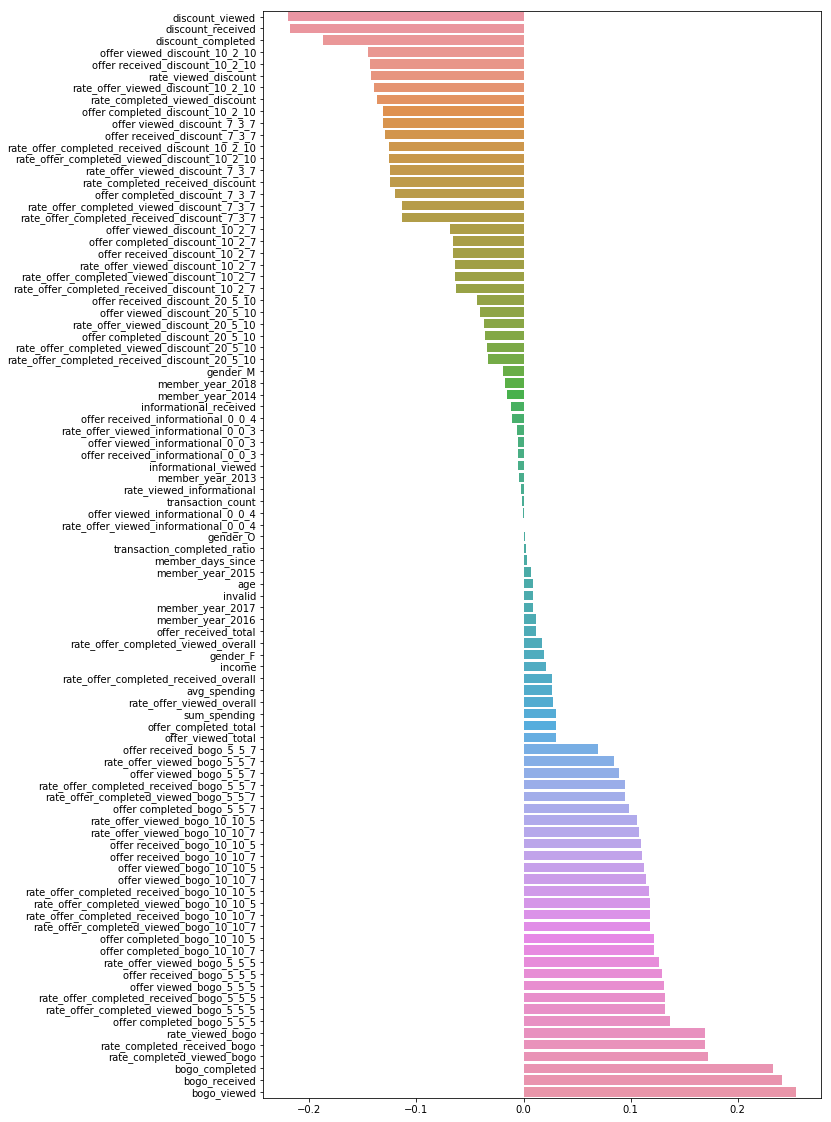

In [148]:
# 2nd PCA comp
plot_weight(profile_std_main,pca_main, 2 )

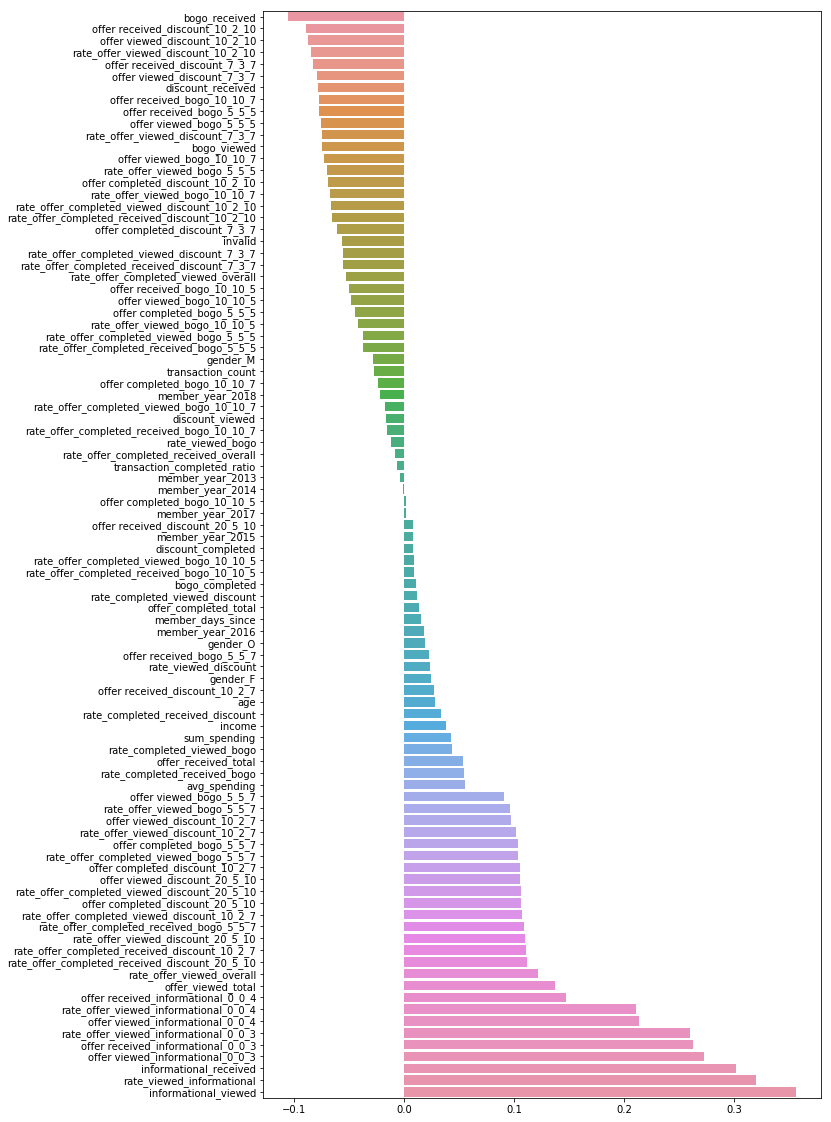

In [149]:
# 3rd PCA comp
plot_weight(profile_std_main,pca_main, 3 )

#### 6.3.2. Special Profile

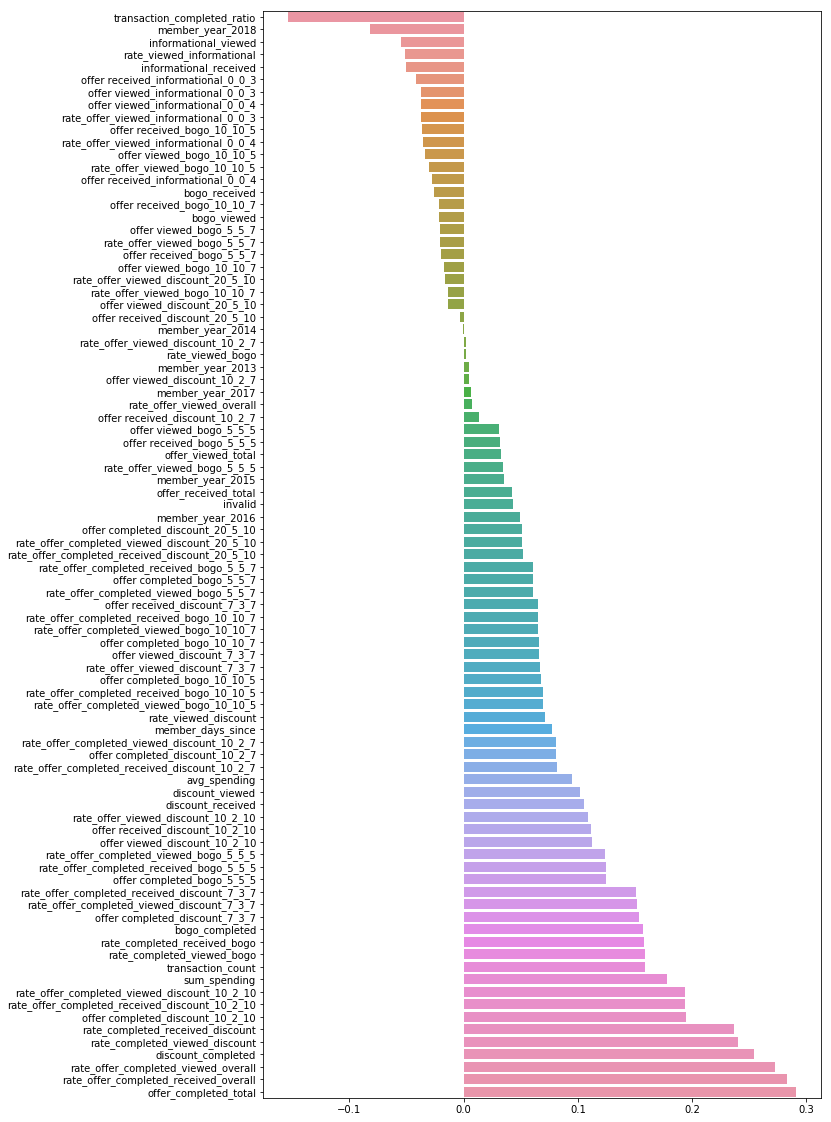

In [150]:
plot_weight(profile_std_sp,pca_sp, 1 )

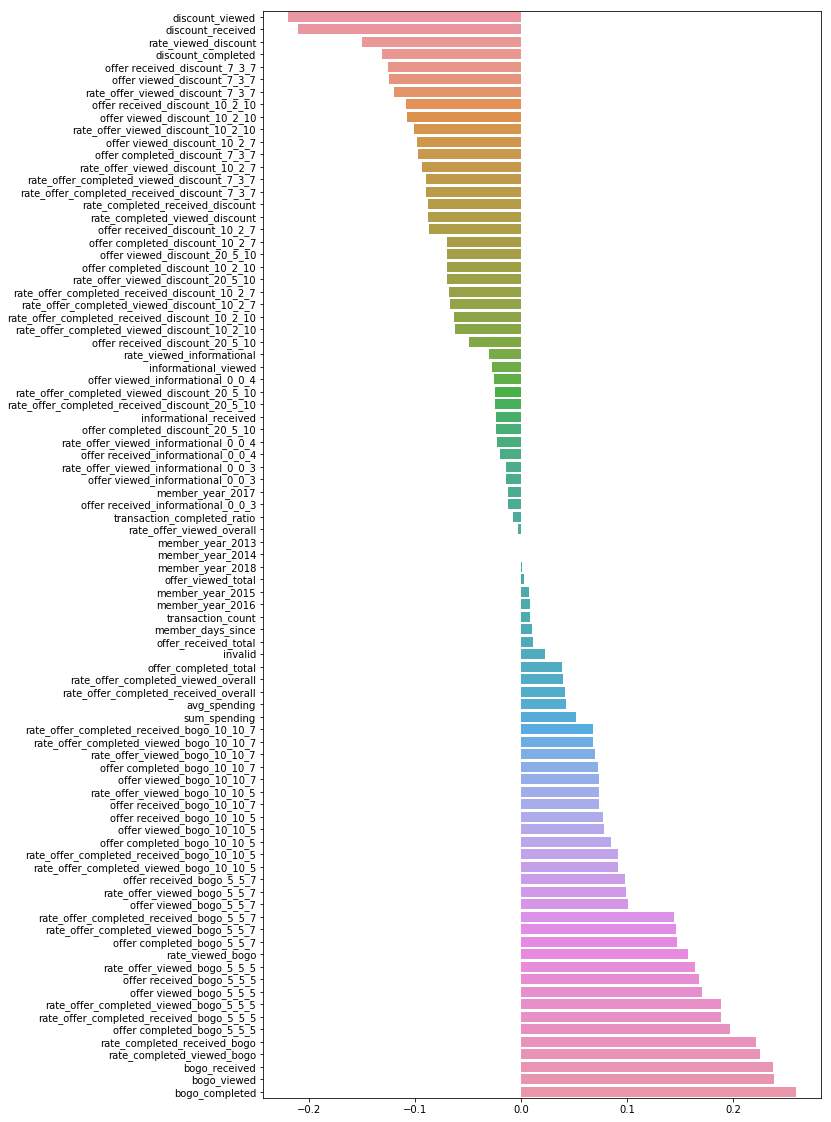

In [151]:
plot_weight(profile_std_sp,pca_sp, 2)

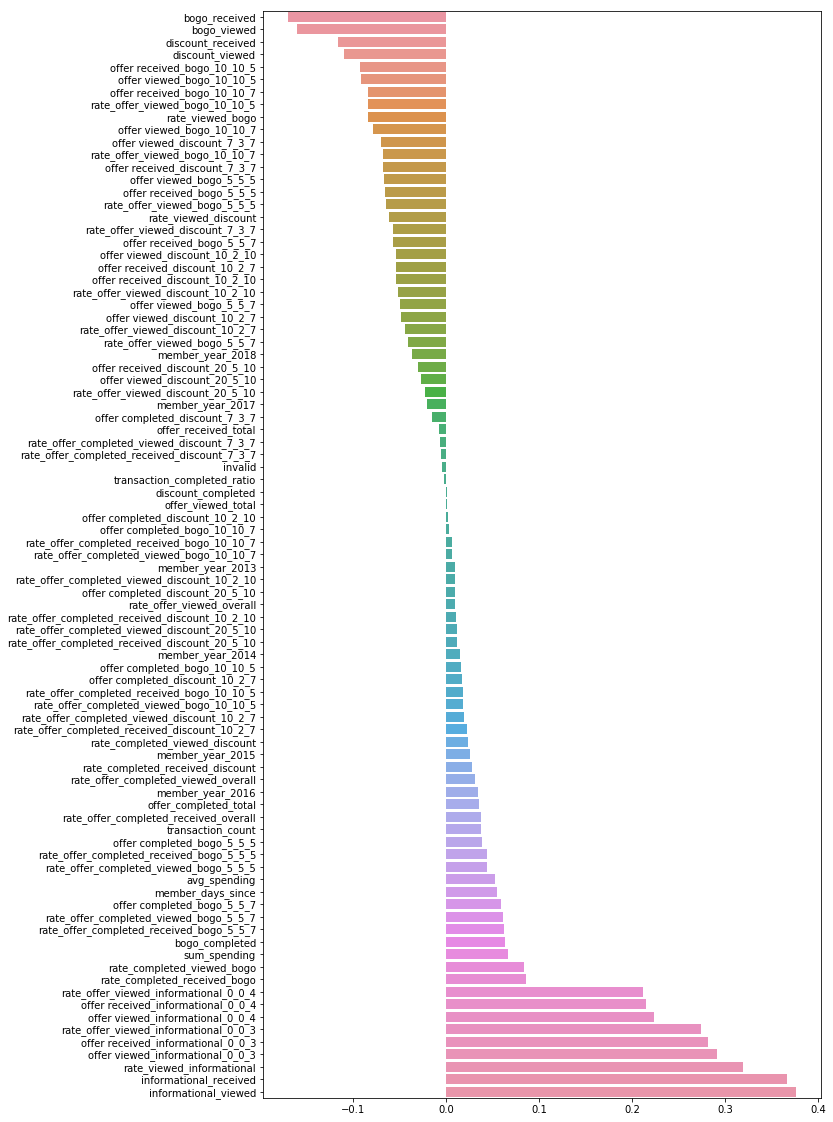

In [152]:
plot_weight(profile_std_sp,pca_sp, 3 )

# Part 3 - Machine Learning Model - Unsupervised

## 7. Clustering

### 7.1 Finding number of clusters

In [8]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import  silhouette_score
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =30):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=42)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="o")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()

100%|██████████| 28/28 [04:06<00:00, 10.04s/it]


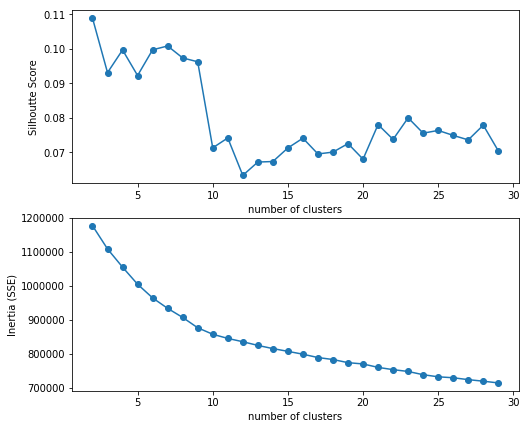

In [9]:
finding_num_cluster(pca_transform_main)

**For main data**, The SSE value may not indicate a clear "Elbow" to choose, however the sillhoutte score at cluster 9 is probably the optimum cluster as the score is still relatively higher and before sudden decreased at cluster 10. So, the selected number of cluster is 9 clusters.

100%|██████████| 28/28 [00:12<00:00,  1.63it/s]


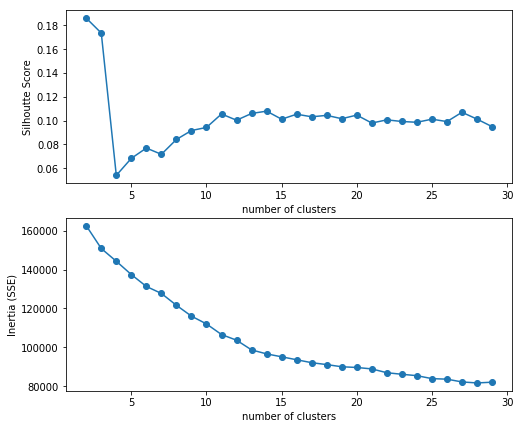

In [10]:
finding_num_cluster(pca_transform_sp)

**For special data**, similar to the main data, The SSE valie did not provide a clear guidance. The selected number of cluster is 11 where the silhoutte score is still higher and the SSE value is relatively lower

### 7.2 Perform K-means clustering

In [166]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_main = KMeans(n_clusters = 9, random_state=42)
preds_main = kmeans_main.fit_predict(pca_transform_main) 
h.save(kmeans_main, 'kmeans_main.sav')

#azdias special data
kmeans_sp = KMeans(n_clusters = 11, random_state=42)
preds_sp = kmeans_sp.fit_predict(pca_transform_sp) 
h.save(kmeans_sp, 'kmeans_sp.sav')

In [6]:
#load

#scaler
scaler_main = h.load('scaler_main.sav')
scaler_sp = h.load('scaler_sp.sav')
profile_std_main = scaler_main.transform(profile_main)
profile_std_sp = scaler_sp.transform(profile_sp)

#pca

pca_main = h.load('pca_main.sav')
pca_sp = h.load('pca_sp.sav')
pca_transform_main = pca_main.transform(profile_std_main)
pca_transform_sp = pca_sp.transform(profile_std_sp)

#kmeans
kmeans_main = h.load('kmeans_main.sav')
kmeans_sp = h.load('kmeans_sp.sav')
preds_main = kmeans_main.predict(pca_transform_main)
preds_sp = kmeans_sp.predict(pca_transform_sp)

In [7]:
profile_cluster_main = profile_main.copy()
profile_cluster_sp = profile_sp.copy()

profile_cluster_main['cluster'] = preds_main
profile_cluster_sp['cluster'] = preds_sp

Text(0.5,1,'Special Profile Data')

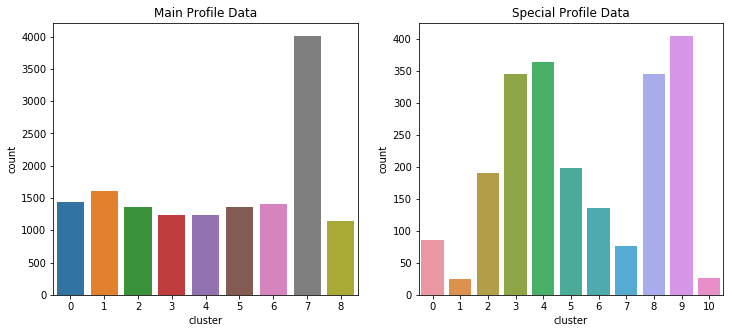

In [17]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
sns.countplot(profile_cluster_main['cluster'], ax=ax1)
ax1.set_title('Main Profile Data')

sns.countplot(profile_cluster_sp['cluster'], ax=ax2)
ax2.set_title('Special Profile Data')

### 7.3 Cluster Analysis on Main Data

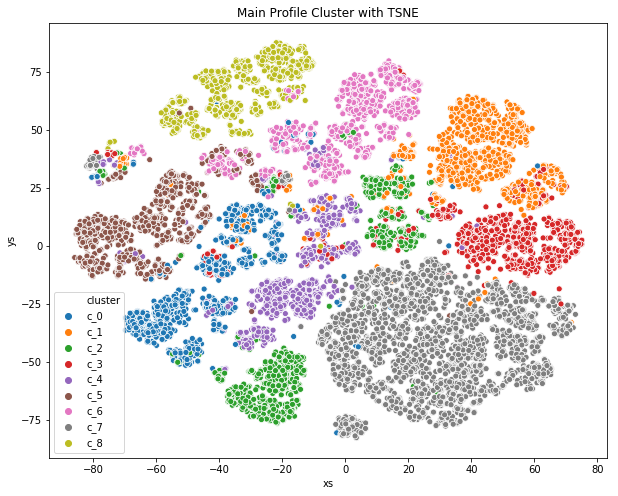

In [67]:
""" Visualise Cluster with TSNE"""
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_main)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_main]

#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,9)])
ax.set_title("Main Profile Cluster with TSNE")
#save fig
f.savefig('main_tsne.png', dpi = 300)

The figure above showed the PCA plot of first and second axes. The higher number of 1st pca is related to high number of offer completed and high rate offer completed, while the lower number is related to informational offer type (high viewed rate) and latest member in 2018. The higher number of 2nd pca is related to BOGO offer type, high number of bogo viewed, and completed, while the lower number is related to DISCOUNT offer type (high number of discount offer viewed and completed).

Cluster 7 clearly showed it is a latest customer who became member on 2018 with low offer completed rate. Cluster 0,2,4,and 5 are customers who tend to preferred BOGO offering while Cluster 1,3, and 6 are customers who preferred DISCOUNT. Cluster 8 probably like both, BOGO and DISCOUNT.



In [25]:
""" Cluster Centroid """

def inverse_transform_centroid(df, kmeans, pca, scaler):
    centers = kmeans.cluster_centers_
    centers_pca = pca.inverse_transform(centers)
    centers = scaler.inverse_transform(centers_pca)
    centers = pd.DataFrame(centers, columns= df.columns)
    return centers

In [30]:
pd.set_option('display.max_columns', 500)

#profile_main_clust_ = profile_main_clust.groupby('cluster').mean()[cols_]
profile_main_centroid = inverse_transform_centroid(profile_main, kmeans_main, pca_main, scaler_main)
profile_main_centroid

age        income  offer received_bogo_10_10_7  \
0  55.565284  69586.417407                     1.330567   
1  53.607053  62667.292914                     0.315386   
2  54.296693  65874.960339                     0.279609   
3  52.722972  61068.516707                     0.332439   
4  57.209809  73316.107008                     0.262683   
5  55.649512  68560.697809                     0.378628   
6  55.491787  68276.157347                     0.332337   
7  52.290184  60274.348933                     0.428146   
8  56.768248  70192.597531                     0.378971   

   offer received_bogo_10_10_5  offer received_informational_0_0_4  \
0                     0.365851                            0.423763   
1                     0.309158                            0.436491   
2                     0.232335                            0.437092   
3                     0.329834                            0.467494   
4                     1.349865                            0.456690   
5                     0.392534                            0.369255   
6                     0.377497                            0.414712   
7                     0.421558                            0.519550   
8                     0.363964                            0.373140   

   offer received_bogo_5_5_7  offer received_discount_20_5_10  \
0                   0.278965                         0.309018   
1                   0.332845                         0.367168   
2                   0.303130                         0.368475   
3                   0.340355                         0.359364   
4                   0.281031                         0.342762   
5                   1.320571                         0.275339   
6                   0.326763                         0.303943   
7                   0.468573                         0.515781   
8                   0.376833                         1.258686   

   offer received_discount_7_3_7  offer received_discount_10_2_10  \
0                       0.373149                         0.371491   
1                       0.371219                         1.353129   
2                       0.400356                         0.355686   
3                       1.429537                         0.213126   
4                       0.342819                         0.377997   
5                       0.401566                         0.369438   
6                       0.421301                         0.411174   
7                       0.294455                         0.299784   
8                       0.394867                         0.372555   

   offer received_informational_0_0_3  offer received_bogo_5_5_5  \
0                            0.401935                   0.405705   
1                            0.422857                   0.240433   
2                            0.440398                   1.342172   
3                            0.414120                   0.280565   
4                            0.447852                   0.386600   
5                            0.433842                   0.420991   
6                            0.425768                   0.344542   
7                            0.520554                   0.363989   
8                            0.380135                   0.381085   

   offer received_discount_10_2_7  offer viewed_bogo_10_10_7  \
0                        0.289413                   1.283242   
1                        0.349240                   0.252031   
2                        0.317081                   0.228019   
3                        0.337394                   0.266876   
4                        0.297111                   0.185628   
5                        0.279228                   0.325151   
6                        1.306038                   0.290538   
7                        0.438531                   0.378469   
8                        0.384168                   0.348753   

   offer viewed_bogo_10_10_5  offer viewed_informatio

In [31]:
""" Standardize Centroid Value """

profile_main_centroid_std = (profile_main_centroid - profile_main_centroid.mean()) / profile_main_centroid.std()

In [27]:
def compare_features(df, features, xlabel = 'cluster', ylabel = 'std value', figsize = (10,8)):
    n_cols = len(features)
    rows = n_cols//2 + (n_cols % 2 >0)
    
    f, axs = plt.subplots(rows,2, figsize=figsize)
    axs = axs.flatten()

    for i in range(n_cols):
        sns.barplot(df.index,features[i], data= df, ax= axs[i])
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(ylabel)
        axs[i].set_title('Feature : ' + features[i])
        
    plt.tight_layout()

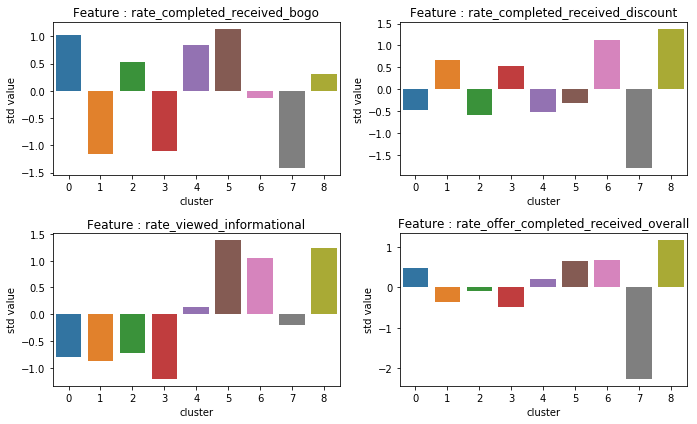

In [143]:
""" Visualize completed rate for each offer and cluster"""

features = [
    'rate_completed_received_bogo',
    'rate_completed_received_discount',
    'rate_viewed_informational',  'rate_offer_completed_received_overall']

compare_features(profile_main_centroid_std, features, figsize=(10,6))

#### Most responsive Clusters 
- **Most offer completed rate** - Cluster 0,4,5,6,8 
- Responsive to **BOGO** : Cluster 0,2,4,5,8
- Responsive to **DISCOUNT** : Cluster 1,3,6,8
- Responsive to **INFORMATIONAL** : Cluster 4,5,6,8


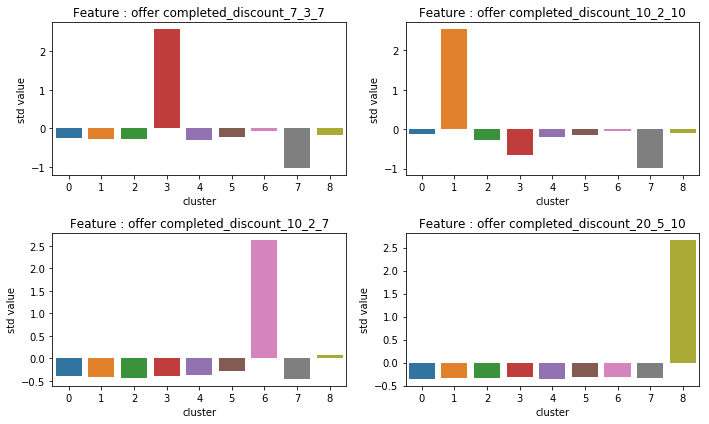

In [138]:
""" Visualize DISCOUNTS """

features = [
    'offer completed_discount_7_3_7',
    'offer completed_discount_10_2_10',
    'offer completed_discount_10_2_7',
    'offer completed_discount_20_5_10']

compare_features(profile_main_centroid_std, features, figsize=(10,6))

#### DISCOUNTS Clusters
- **Cluster 3** - very responsive to the lowest difficulty (7)
- **Cluster 1 & 6** - very reponsive to medium difficulty (10), the differences only in discount duration 
- **Cluster 8** - very responsive to the highest difficulty (20)

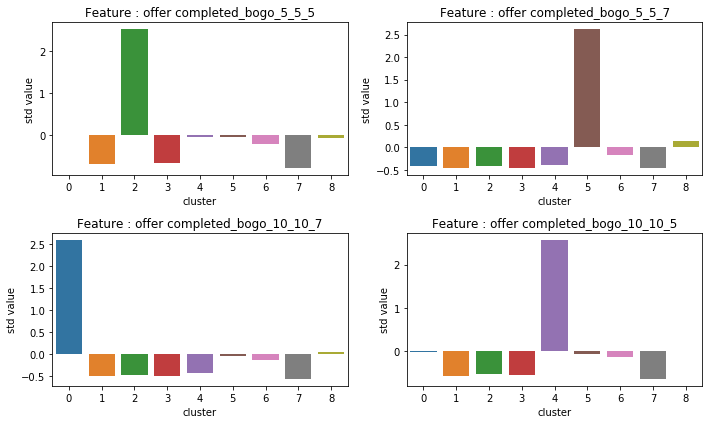

In [126]:
""" Visualize BOGO related cluster """
features= [
    'offer completed_bogo_5_5_5',
    'offer completed_bogo_5_5_7',
    'offer completed_bogo_10_10_7',
    'offer completed_bogo_10_10_5']

compare_features(profile_main_centroid_std, features, figsize=(10,6))

#### BOGO Clusters
- **Cluster 2 & 5** - very responsive to the lowest difficulty (5), only differ in bogo duration.
- **Cluster 0 & 4** - very reponsive to highest difficulty (10), only differ in bogo duration 

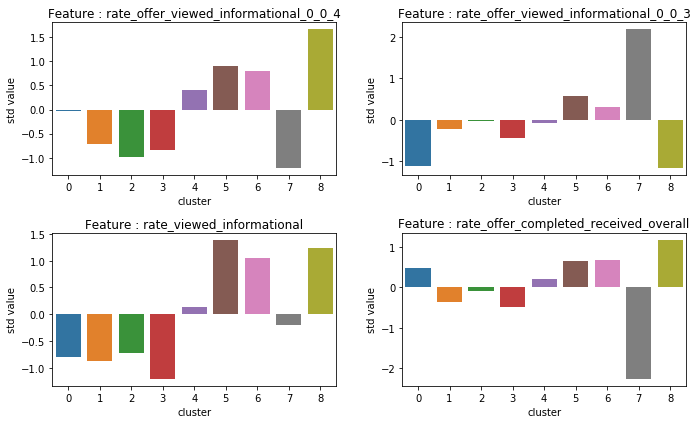

In [144]:
""" Visualize INFORMATIONAL related cluster """

features= ['rate_offer_viewed_informational_0_0_4',
     'rate_offer_viewed_informational_0_0_3',  'rate_viewed_informational','rate_offer_completed_received_overall']

compare_features(profile_main_centroid_std, features, figsize=(10,6))

#### INFORMATIONAL Clusters
- **Cluster 3** - responsive to the lowest difficulty (7)
- **Cluster 1 & 6** - reponsive to medium difficulty (10), the differences only in discount duration 
- **Cluster 8** - responsive to the highest difficulty (20)
- **Cluster 0** - not a very responsive to informational but higher offer completed rate. 

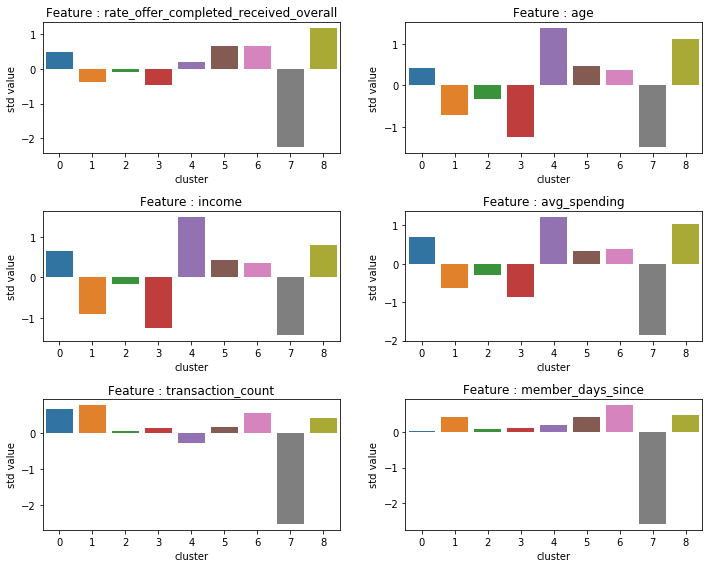

In [130]:
""" Visualize other features """

features= ['rate_offer_completed_received_overall', 'age', 'income', 'avg_spending',
           'transaction_count','member_days_since' ]

compare_features(profile_main_centroid_std, features, figsize=(10,8))

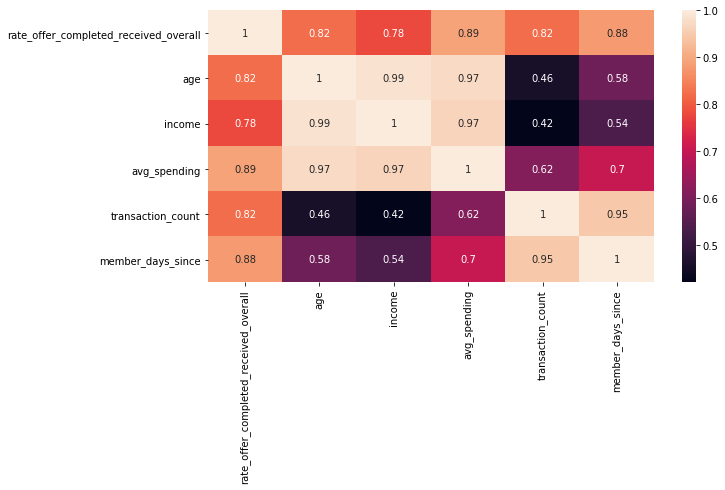

In [84]:
features= ['rate_offer_completed_received_overall', 'age', 'income', 'avg_spending',
           'transaction_count','member_days_since' ]

f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(profile_main_centroid_std[features].corr(), annot=True, ax=ax)

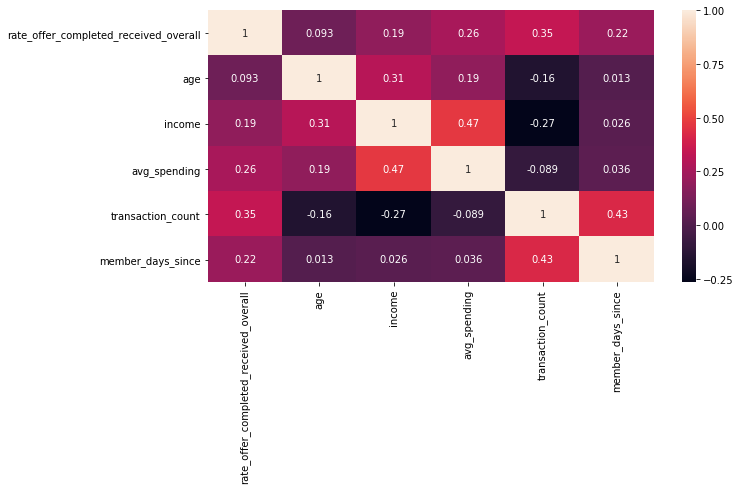

In [85]:
features= ['rate_offer_completed_received_overall', 'age', 'income', 'avg_spending',
           'transaction_count','member_days_since' ]

f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(profile_cluster_main[features].corr(), annot=True, ax=ax)

**Other feature notes** :
- `rate_offer_completed`, `Income`, `Age`, and `avg_spending` is highly correlated
- Cluster 8 - oldest age and membership, most income & average spending, relative higher transaction & offer completed rate
- Cluster 7 - just the opposite of cluster 8


In [16]:
""" create gender df """
genders = ['gender_F','gender_M', 'gender_O']
gender_df = profile_cluster_main[['gender_F','gender_M', 'gender_O', 'cluster']]#.idxmax(axis=1)#.shape
gender_df['gender'] = gender_df[genders].idxmax(axis=1)
gender_df = gender_df.drop(genders, axis=1)

""" create member_year df """
members = profile_cluster_main.columns[profile_cluster_main.columns.str.contains('member_year')].tolist()
member_df = profile_cluster_main[members + ['cluster']]#.idxmax(axis=1)#.shape
member_df['member_year'] = member_df[members].idxmax(axis=1)
member_df = member_df.drop(members, axis=1)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


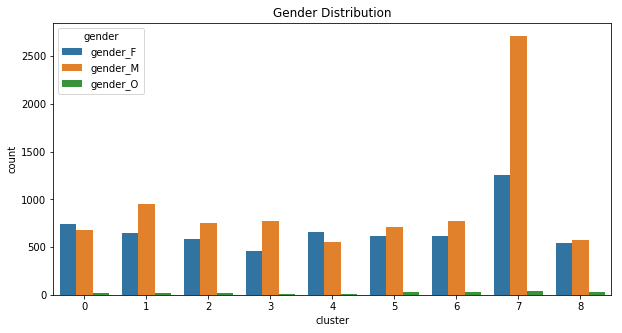

In [17]:
f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='gender', data= gender_df, ax=ax)
ax.set_title("Gender Distribution");

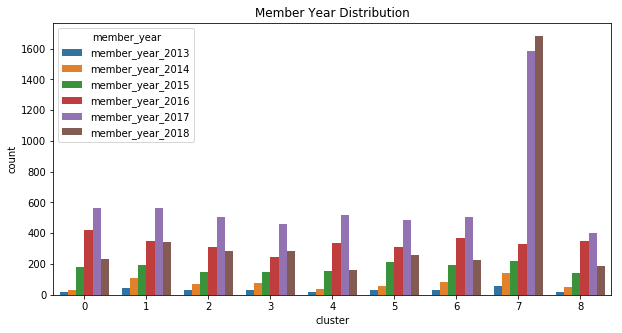

In [19]:
f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='member_year', data= member_df, ax=ax,
             hue_order = ['member_year_' + str(i) for i in range(2013,2019,1)])
ax.set_title("Member Year Distribution");

### Cluster Analysis Summary :

- **BOGO** Cluster who response to bogo offering 
    - `Cluster 0` : above average income, average spending amount, offer completed rate
    - `Cluster 2` : slighlty below average income & spending, and lower offer completed rate
    - `Cluster 4` : the highest income and average spending amount, older group
    - `Cluster 5` : similar to `cluster 0`, but very response to informational offer
- **DISCOUNT** Cluster who response to discount offering
    - `Cluster 1` : below average income, spending and offer completed rate
    - `Cluster 3` : similar to `cluster 1` with the lowest income and spending
    - `Cluster 6` : above average income, spending and offer completed rate who very responsice to informational and discount offering
- **BOGO & DISCOUNT** Cluster who respons both bogo and discount offering
    - `Cluster 8` : very responsive to informational and discount, and also repsonsive to bogo offering, above average income, spending with most offer completed rate with the highest difficulty
- **INFORMATIONAL** Cluster who response informational offering
    - `Cluster 4, 5, 6, and 8`, and some `cluster 7`
    
- Probably not a targetted cluster:
    - `Cluster 7` : newer member who has the lowest income & offer completed rate, and probably never have a spending, may have responsive to informational offer.


**Below is the summary table.**

<img src="main_cluster_summary.png"/>
Note : PLUS (+) sign indicate above average, the more (+) shows higher value up to 5 (+++++) while NEGATIVE (-) sign is the opposite.


**Summary Cluster with TSNE**
<img src="main_tsne_annot.png"/>

### 7.4 Cluster Analysis on Special Data

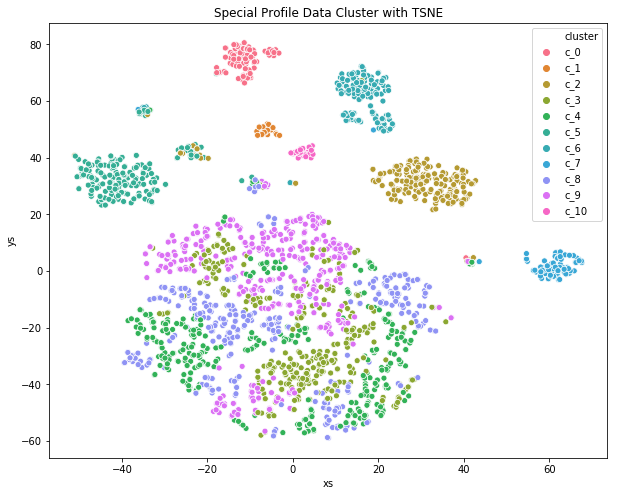

In [88]:
""" Visualise Cluster with TSNE"""
from sklearn.manifold import TSNE

tsne = TSNE(random_state=42).fit_transform(pca_transform_sp)
tsne_df = pd.DataFrame(tsne, columns=['xs', 'ys'])
tsne_df['cluster'] = ['c_' + str(i) for i in preds_sp]


#plot tsne
f,ax = plt.subplots(figsize=(10,8))
sns.scatterplot('xs','ys', hue='cluster', data=tsne_df, ax=ax, hue_order=['c_' + str(i) for i in range(0,11)])
ax.set_title('Special Profile Data Cluster with TSNE')
f.savefig('special_tsne.png', dpi = 300)

In [66]:
""" Cluster Centroid """
pd.set_option('display.max_columns', 500)

#profile_main_clust_ = profile_main_clust.groupby('cluster').mean()[cols_]
profile_sp_centroid = inverse_transform_centroid(profile_sp, kmeans_sp, pca_sp, scaler_sp)
profile_sp_centroid

offer received_bogo_10_10_7  offer received_bogo_10_10_5  \
0                      0.401034                     0.345134   
1                      0.436799                     1.320118   
2                      0.367118                     0.406528   
3                      0.661280                     1.072202   
4                      0.378897                     0.373176   
5                      0.428365                     0.403790   
6                      0.374190                     0.248682   
7                      0.388615                     0.299819   
8                      0.376866                     0.346515   
9                      0.427296                     0.253419   
10                     1.210462                     0.217913   

    offer received_informational_0_0_4  offer received_bogo_5_5_7  \
0                             0.451154                   1.287313   
1                             0.524457                   0.371483   
2                             0.406969                   0.315924   
3                             0.193263                   0.719327   
4                             0.167427                   0.337228   
5                             0.444118                   0.351247   
6                             0.406640                   0.328269   
7                             0.520613                   0.322087   
8                             1.289560                   0.358701   
9                             0.196870                   0.438670   
10                            0.257938                   0.228090   

    offer received_discount_20_5_10  offer received_discount_7_3_7  \
0                          0.438600                       0.413078   
1                          0.284860                       0.318331   
2                          0.405447                       0.301388   
3                          0.240144                       0.223806   
4                          0.458977                       0.309370   
5                          0.436799                       1.259438   
6                          0.467739                       0.339279   
7                          0.341598                       0.347461   
8                          0.426918                       0.379318   
9                          0.612417                       0.593787   
10                         0.297676                       0.444778   

    offer received_discount_10_2_10  offer received_informational_0_0_3  \
0                          0.339287                            0.502476   
1                          0.437756                            0.226951   
2                          1.330917                            0.439818   
3                          0.180587                            0.169723   
4                          0.279864                            1.335479   
5                          0.333453                            0.390156   
6                          0.434197                            0.381295   
7                          0.345528                            0.372815   
8                          0.367675                            0.285974   
9                          0.514463                            0.096587   
10                         0.595075                            0.404762   

    offer received_bogo_5_5_5  offer received_discount_10_2_7  \
0                    0.366025                        0.232285   
1                    0.567766                        0.395011   
2                    0.405996                        0.393621   
3                    0.802382                        0.315310   
4                    0.295862                        0.442573   
5                    0.309337                        0.296244   
6                    1.315267                        0.380512   
7                    0.224517                        1.433109   
8                    0.337634                        0.397376   
9             

In [32]:
""" Standardize Centroid Value """

profile_sp_centroid_std = (profile_sp_centroid - profile_sp_centroid.mean()) / profile_sp_centroid.std()

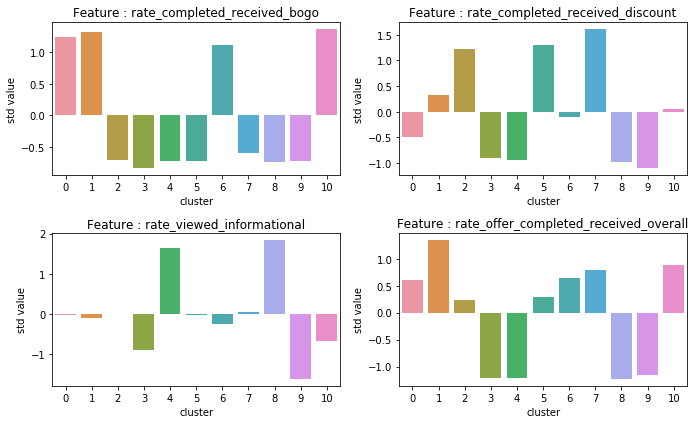

In [35]:
""" Visualize completed rate for each offer and cluster"""

features = [
    'rate_completed_received_bogo',
    'rate_completed_received_discount',
    'rate_viewed_informational',  'rate_offer_completed_received_overall']

compare_features(profile_sp_centroid_std, features, figsize=(10,6))

#### Most responsive Clusters 
- **Most offer completed rate** - `Cluster 0,1,2,5,6,7, and 10`
- Responsive to **BOGO** : `Cluster 0,1,6, and 10`
- Responsive to **DISCOUNT** : `Cluster 1,2,5,7, and 10`
- Responsive to **INFORMATIONAL** : `Cluster 4 and 8`

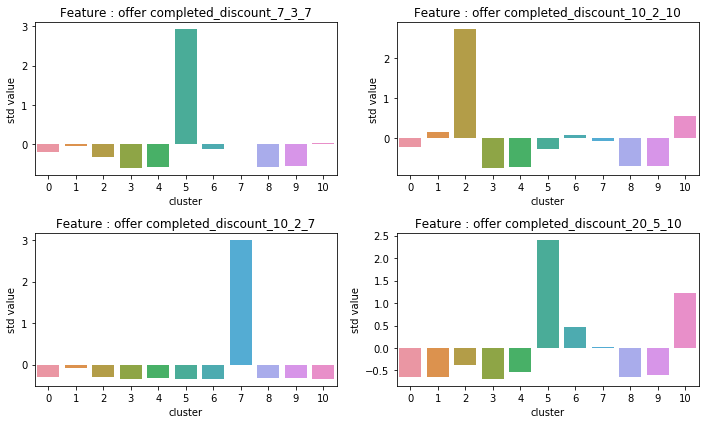

In [36]:
""" Visualize DISCOUNTS """

features = [
    'offer completed_discount_7_3_7',
    'offer completed_discount_10_2_10',
    'offer completed_discount_10_2_7',
    'offer completed_discount_20_5_10']

compare_features(profile_sp_centroid_std, features, figsize=(10,6))

#### DISCOUNTS Clusters
- **`Cluster 5`** - very responsive to the lowest difficulty (7)
- **`Cluster 2 & 7`** - very reponsive to medium difficulty (10), the differences only in discount duration 
- **`Cluster 5, 6, and 10`** - very responsive to the highest difficulty (20)

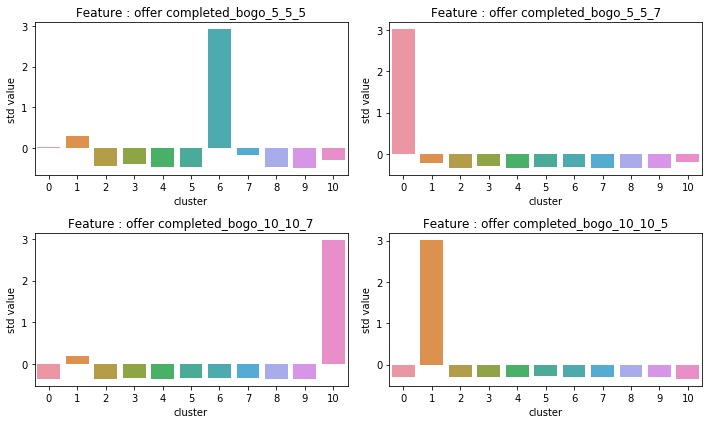

In [37]:
""" Visualize BOGO related cluster """
features= [
    'offer completed_bogo_5_5_5',
    'offer completed_bogo_5_5_7',
    'offer completed_bogo_10_10_7',
    'offer completed_bogo_10_10_5']

compare_features(profile_sp_centroid_std, features, figsize=(10,6))

#### BOGO Clusters
- **`Cluster 0, 2 & 6`** - very responsive to the lowest difficulty (5), only differ in bogo duration.
- **`Cluster 1 & 10`** - very reponsive to highest difficulty (10), only differ in bogo duration 

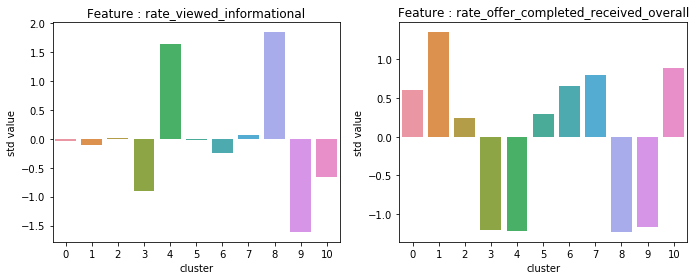

In [50]:
""" Visualize INFORMATIONAL related cluster """

features= [ 'rate_viewed_informational','rate_offer_completed_received_overall']

compare_features(profile_sp_centroid_std, features, figsize=(10,4))

#### INFORMATIONAL Clusters
- **`Cluster 4 & 9`** - very responsive to informational offer, but not on other offer as they are the lowest offer completed rate
- **`Cluster 1 & 10`** - not a very responsive to informational but highest offer completed rate. 

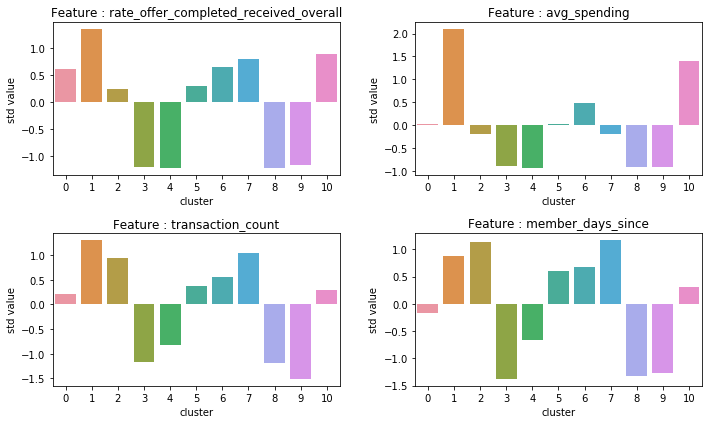

In [41]:
""" Visualize other features """

features= ['rate_offer_completed_received_overall',  'avg_spending',
           'transaction_count','member_days_since' ]

compare_features(profile_sp_centroid_std, features, figsize=(10,6))

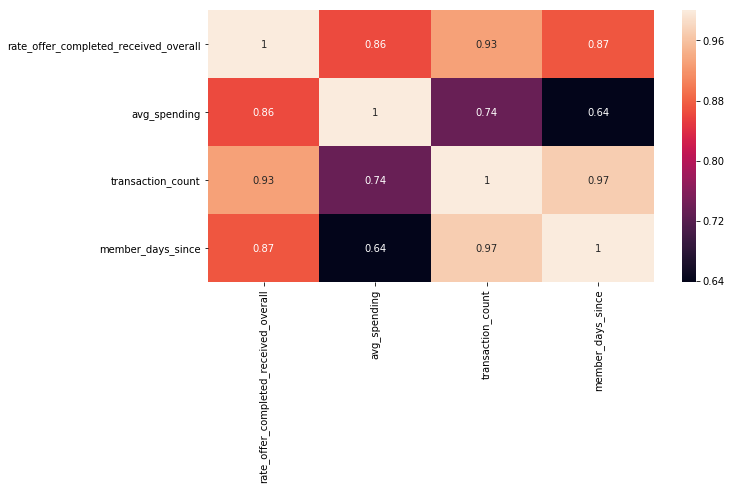

In [56]:
features= ['rate_offer_completed_received_overall',  'avg_spending',
           'transaction_count','member_days_since' ]

f, ax = plt.subplots(figsize=(10,5))
sns.heatmap(profile_sp_centroid_std[features].corr(), annot=True, ax=ax)

**Other feature notes** :
- `rate_offer_completed`, `avg_spending`, `transaction_count`, `member_days_since` are highly correlated
- `Cluster 3,4,8, and 9` - newer member tend to have lower offer `completed rate / avg_spending / transaction `

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


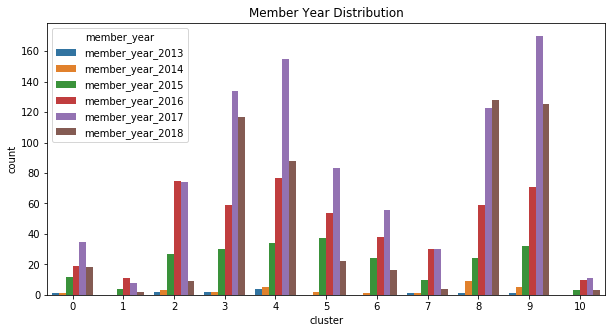

In [47]:
""" visualize member year """
members = profile_cluster_sp.columns[profile_cluster_sp.columns.str.contains('member_year')].tolist()
member_df = profile_cluster_sp[members + ['cluster']]#.idxmax(axis=1)#.shape
member_df['member_year'] = member_df[members].idxmax(axis=1)
member_df = member_df.drop(members, axis=1)

f, ax= plt.subplots(figsize=(10,5))
sns.countplot('cluster', hue='member_year', data= member_df, ax=ax,
             hue_order = ['member_year_' + str(i) for i in range(2013,2019,1)])
ax.set_title("Member Year Distribution");

#### Cluster Analysis Summary for SPECIAL PROFILE :

- **BOGO** Cluster who response to bogo offering 
    - `Cluster 0` : responsive to bogo with the lowest difficulty
    - `Cluster 1` : similar to `cluster 0` with the highest average spending and higher difficulty
    - `Cluster 6` : similar to `cluster 0` with the highest average spending.
    - `Cluster 10` : very similar to `cluster 1` 
- **DISCOUNT** Cluster who response to discount offering
    - `Cluster 1` : other than bogo, this cluster also responsive to discount.
    - `Cluster 2` : responsive to discount with the higher difficulty but less avg_spending
    - `Cluster 5` : similar to `cluster 2` with slightly higher avg_spending
    - `Cluster 7` : similar to `'cluster 2` with higher responsive 
    - `Cluster 10` : other than bogo, slightly responsive to discount
- **BOGO & DISCOUNT** Cluster who respons both bogo and discount offering
    - `Cluster 1 & 10` 
- **INFORMATIONAL** Cluster who response informational offering
    - `Cluster 0, 2 and 7` : slightly responsive to informational but very responsive to bogo or discount
    - `Cluster 4 & 8` : very responsive to informational but lowest `avg_spending & offer completed rate`
        
- Probably not a targetted cluster:
    - `Cluster 3 & 9` : not responsive to any offering and the lowest `avg_spending & offer completed rate` , mostly newer member



**Below is the summary table for SPECIAL PROFILE.**


<img src="sp_cluster_summary.png"/>
Note : PLUS (+) sign indicate above average, the more (+) shows higher value up to 5 (+++++) while NEGATIVE (-) sign is the opposite.


**Summary Cluster with TSNE**
<img src="special_tsne_annot.png"/>

## 8. Who and What type of offering to sent ?

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers

### 8.1 Main Profile

#### 8.1.1 Bogo & Discount

In [72]:
def assign_offer_type(profile_cluster, bogos, discounts):
    profile_target_main = profile_cluster.copy()

    for bogo in bogos:
        #bogo subset
        subset_5 = (profile_target_main.cluster == bogo) & (profile_target_main.avg_spending < 5)
        subset_10 = (profile_target_main.cluster == bogo) & (profile_target_main.avg_spending < 10)\
                    & (profile_target_main.avg_spending >= 5)
        subset_10_ = (profile_target_main.cluster == bogo) & (profile_target_main.avg_spending >= 10) & \
        (profile_target_main['rate_offer_completed_received_overall'] >= profile_target_main['rate_offer_completed_received_overall'].mean()) & \
        (profile_target_main['transaction_count'] < profile_target_main['transaction_count'].mean())

        #create new columns bogos
        profile_target_main.loc[subset_5, "bogo_5"] = 1
        profile_target_main.loc[subset_10, "bogo_10"] = 1
        profile_target_main.loc[subset_10_, "bogo_10"] = 1

    for discount in discounts:
         #discpunt subset
        subset_7 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 7)
        subset_10 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 10)\
                    & (profile_target_main.avg_spending >= 7)
        subset_20 = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending < 20)\
                    & (profile_target_main.avg_spending >= 10)
        subset_20_ = (profile_target_main.cluster == discount) & (profile_target_main.avg_spending >= 10) & \
            (profile_target_main['rate_offer_completed_received_overall'] >= profile_target_main['rate_offer_completed_received_overall'].mean()) & \
            (profile_target_main['transaction_count'] < profile_target_main['transaction_count'].mean())

        #create new columns discounts
        profile_target_main.loc[subset_7, "discount_7"] = 1
        profile_target_main.loc[subset_10, "discount_10"] = 1
        profile_target_main.loc[subset_20, "discount_20"] = 1
        profile_target_main.loc[subset_20_, "discount_20"] = 1

    profile_target_main = profile_target_main.fillna(0)
    
    return profile_target_main

In [73]:
bogos = [0, 2, 4, 5]
discounts = [1,3, 6, 8]
target_main = assign_offer_type(profile_cluster_main, bogos, discounts)
target_main.head()

age    income  offer received_bogo_10_10_7  \
Unnamed: 0                                                                     
0610b486422d4921ae7d2bf64640c50b   55  112000.0                          0.0   
78afa995795e4d85b5d9ceeca43f5fef   75  100000.0                          1.0   
e2127556f4f64592b11af22de27a7932   68   70000.0                          0.0   
389bc3fa690240e798340f5a15918d5c   65   53000.0                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d   58   51000.0                          0.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
0610b486422d4921ae7d2bf64640c50b                          0.0   
78afa995795e4d85b5d9ceeca43f5fef                          0.0   
e2127556f4f64592b11af22de27a7932                          0.0   
389bc3fa690240e798340f5a15918d5c                          0.0   
2eeac8d8feae4a8cad5a6af0499a211d                          0.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 1.0   
78afa995795e4d85b5d9ceeca43f5fef                                 0.0   
e2127556f4f64592b11af22de27a7932                                 1.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 1.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
0610b486422d4921ae7d2bf64640c50b                        1.0   
78afa995795e4d85b5d9ceeca43f5fef                        1.0   
e2127556f4f64592b11af22de27a7932                        1.0   
389bc3fa690240e798340f5a15918d5c                        2.0   
2eeac8d8feae4a8cad5a6af0499a211d                        0.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              0.0   
389bc3fa690240e798340f5a15918d5c                              0.0   
2eeac8d8feae4a8cad5a6af0499a211d                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
0610b486422d4921ae7d2bf64640c50b                            0.0   
78afa995795e4d85b5d9ceeca43f5fef                            0.0   
e2127556f4f64592b11af22de27a7932                            0.0   
389bc3fa690240e798340f5a15918d5c                            0.0   
2eeac8d8feae4a8cad5a6af0499a211d                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
0610b486422d4921ae7d2bf64640c50b                              0.0   
78afa995795e4d85b5d9ceeca43f5fef                              0.0   
e2127556f4f64592b11af22de27a7932                              1.0   
389bc3fa690240e798340f5a15918d5c                              1.0   
2eeac8d8feae4a8cad5a6af0499a211d                              1.0   

                                  offer received_informational_0_0_3  \
Unnamed: 0                                                             
0610b486422d4921ae7d2bf64640c50b                                 0.0   
78afa995795e4d85b5d9ceeca43f5fef                                 1.0   
e2127556f4f64592b11af22de27a7932                                 0.0   
389bc3fa690240e798340f5a15918d5c                                 0.0   
2eeac8d8feae4a8cad5a6af0499a211d                                 0.0   

                                     ...       member_year_2015  \
Unnamed: 0                           ...                    

In [74]:
def calc_assign_offer(profile_target_df):
    
    cluster_max = profile_target_df.cluster.max()
    target_cols = ['bogo_5', 'bogo_10', 'discount_7', 'discount_10','discount_20']
    target_summary = pd.DataFrame()

    for cluster in range(0,cluster_max+1):
        cluster_series = pd.Series(name=cluster)
        total_cluster = profile_target_df[profile_target_df.cluster==cluster]
        cluster_series['total_cluster'] = total_cluster.shape[0]
        for col in target_cols:
            cluster_series[col] = total_cluster[col].sum()

        target_summary = pd.concat([target_summary, cluster_series], axis=1, sort=True)

    target_summary_ = target_summary.T
    target_summary_['target'] = target_summary_[target_cols].sum(axis=1)
    target_summary_['target_frac'] = target_summary_.target / target_summary_.total_cluster
    target_summary_['not_target'] = target_summary_.total_cluster - target_summary_.target
    return target_summary_

In [75]:
target_main_summary = calc_assign_offer(target_main)
target_main_summary

bogo_10  bogo_5  discount_10  discount_20  discount_7  total_cluster  \
0    568.0    68.0          0.0          0.0         0.0         1443.0   
1      0.0     0.0         81.0        510.0       688.0         1611.0   
2    374.0   386.0          0.0          0.0         0.0         1353.0   
3      0.0     0.0         63.0        358.0       578.0         1244.0   
4    479.0    56.0          0.0          0.0         0.0         1230.0   
5    560.0   178.0          0.0          0.0         0.0         1356.0   
6      0.0     0.0         92.0        830.0       220.0         1414.0   
7      0.0     0.0          0.0          0.0         0.0         4011.0   
8      0.0     0.0         55.0        798.0        42.0         1146.0   

   target  target_frac  not_target  
0   636.0     0.440748       807.0  
1  1279.0     0.793917       332.0  
2   760.0     0.561715       593.0  
3   999.0     0.803055       245.0  
4   535.0     0.434959       695.0  
5   738.0     0.544248       618.0  
6  1142.0     0.807638       272.0  
7     0.0     0.000000      4011.0  
8   895.0     0.780977       251.0

In [76]:
def plot_assign_offer(summary_df):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)
    summary_df[['bogo_5','bogo_10', 'discount_7', 'discount_10', 'discount_20']].plot(kind='bar', stacked=True, ax=ax1)
    summary_df[['target', 'not_target']].plot(kind='bar', stacked=True, ax=ax2)

    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0);
    ax2.set_xticklabels(ax2.get_xticklabels(),rotation=0);
    ax1.set_title('Bogo & Discount Target Profile')
    ax2.set_title('Target Profile for Bogo & Discount')
    ax1.set_xlabel('Cluster')
    ax2.set_xlabel('Cluster')
    ax1.set_ylabel('Total Count')
    plt.tight_layout()

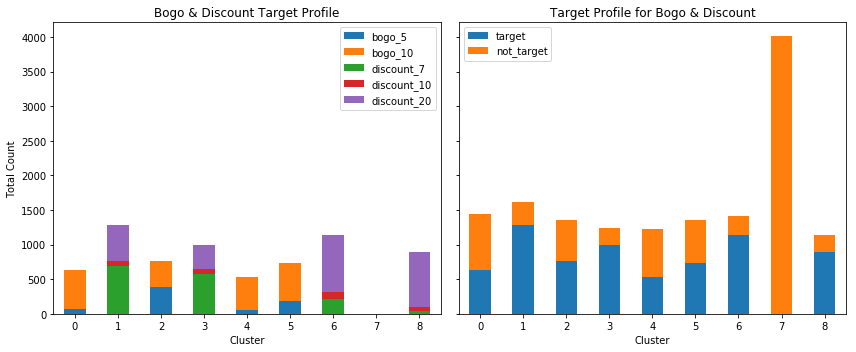

In [77]:
plot_assign_offer(target_main_summary)

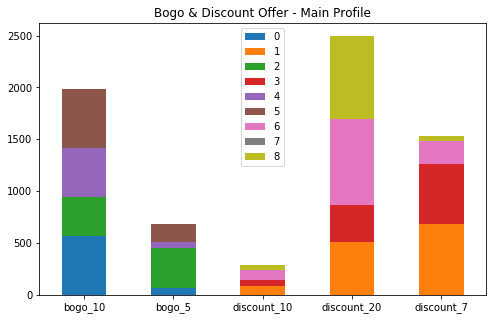

In [121]:
f, ax = plt.subplots(figsize=(8,5))
target_main_summary.loc[:, target_sp_summary.columns.str.contains("bogo|discount")].T.plot(kind='bar',stacked=True,ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Bogo & Discount Offer - Main Profile');


#### 8.1.2 Informational Offer

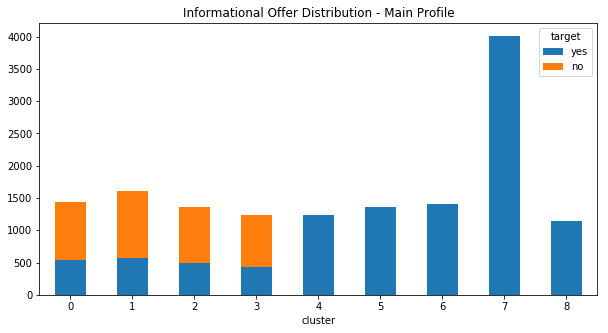

In [105]:
clust_info_main = profile_cluster_main.copy()
clust_info_main.loc[clust_info_main.cluster.isin([4,5,6,7,8]), 'target'] = "yes"
clust_info_main.loc[clust_info_main['rate_viewed_informational'] >= 0.8, 'target'] = 'yes'
clust_info_main['target'] = clust_info_main['target'].fillna("no")

f, ax = plt.subplots(figsize=(10,5))
clust_info_main.groupby(['cluster', 'target']).size().unstack()[['yes','no']].plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Informational Offer Distribution - Main Profile');

#### 8.1.2. Put it all together

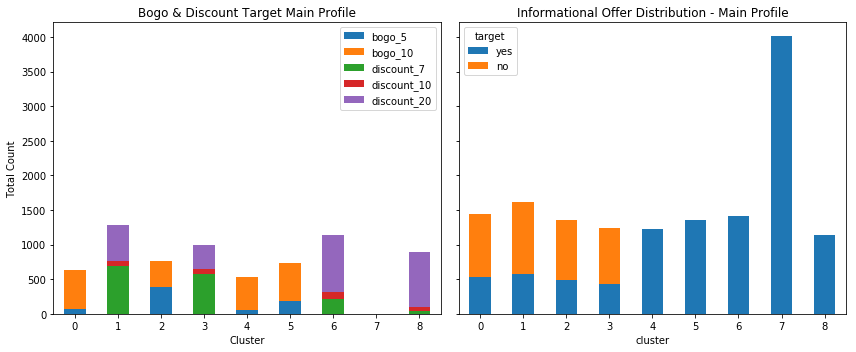

In [126]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)

target_main_summary[['bogo_5','bogo_10', 'discount_7', 'discount_10', 'discount_20']].plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0);
ax1.set_title('Bogo & Discount Target Main Profile')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Count')

clust_info_main.groupby(['cluster', 'target']).size().unstack()[['yes','no']].plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0);
ax2.set_title('Informational Offer Distribution - Main Profile');

plt.tight_layout()


### 8.2 Special Profile

#### 8.2.1 Bogo and Discount

In [78]:
bogos = [0, 6,10]
discounts = [1,2,5,7]
target_sp = assign_offer_type(profile_cluster_sp, bogos, discounts)
target_sp.head()

offer received_bogo_10_10_7  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          0.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_bogo_10_10_5  \
Unnamed: 0                                                      
68be06ca386d4c31939f3a4f0e3dd783                          0.0   
38fe809add3b4fcf9315a9694bb96ff5                          0.0   
a03223e636434f42ac4c3df47e8bac43                          0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                          1.0   
68617ca6246f4fbc85e91a2a49552598                          1.0   

                                  offer received_informational_0_0_4  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 0.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 1.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_7  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5                        1.0   
a03223e636434f42ac4c3df47e8bac43                        0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                        0.0   
68617ca6246f4fbc85e91a2a49552598                        1.0   

                                  offer received_discount_20_5_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              1.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              3.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              0.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_discount_7_3_7  \
Unnamed: 0                                                        
68be06ca386d4c31939f3a4f0e3dd783                            1.0   
38fe809add3b4fcf9315a9694bb96ff5                            0.0   
a03223e636434f42ac4c3df47e8bac43                            0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                            0.0   
68617ca6246f4fbc85e91a2a49552598                            1.0   

                                  offer received_discount_10_2_10  \
Unnamed: 0                                                          
68be06ca386d4c31939f3a4f0e3dd783                              2.0   
38fe809add3b4fcf9315a9694bb96ff5                              0.0   
a03223e636434f42ac4c3df47e8bac43                              0.0   
8ec6ce2a7e7949b1bf142def7d0e0586                              2.0   
68617ca6246f4fbc85e91a2a49552598                              0.0   

                                  offer received_informational_0_0_3  \
Unnamed: 0                                                             
68be06ca386d4c31939f3a4f0e3dd783                                 0.0   
38fe809add3b4fcf9315a9694bb96ff5                                 1.0   
a03223e636434f42ac4c3df47e8bac43                                 1.0   
8ec6ce2a7e7949b1bf142def7d0e0586                                 0.0   
68617ca6246f4fbc85e91a2a49552598                                 0.0   

                                  offer received_bogo_5_5_5  \
Unnamed: 0                                                    
68be06ca386d4c31939f3a4f0e3dd783                        0.0   
38fe809add3b4fcf9315a9694bb96ff5           

In [79]:
target_sp_summary = calc_assign_offer(target_sp)
target_sp_summary

bogo_10  bogo_5  discount_10  discount_20  discount_7  total_cluster  \
0       7.0    75.0          0.0          0.0         0.0           86.0   
1       0.0     0.0          3.0          5.0        16.0           25.0   
2       0.0     0.0          2.0          8.0       180.0          190.0   
3       0.0     0.0          0.0          0.0         0.0          344.0   
4       0.0     0.0          0.0          0.0         0.0          363.0   
5       0.0     0.0          2.0         10.0       185.0          198.0   
6      14.0   114.0          0.0          0.0         0.0          135.0   
7       0.0     0.0          3.0          3.0        70.0           76.0   
8       0.0     0.0          0.0          0.0         0.0          344.0   
9       0.0     0.0          0.0          0.0         0.0          404.0   
10     10.0    15.0          0.0          0.0         0.0           27.0   

    target  target_frac  not_target  
0     82.0     0.953488         4.0  
1     24.0     0.960000         1.0  
2    190.0     1.000000         0.0  
3      0.0     0.000000       344.0  
4      0.0     0.000000       363.0  
5    197.0     0.994949         1.0  
6    128.0     0.948148         7.0  
7     76.0     1.000000         0.0  
8      0.0     0.000000       344.0  
9      0.0     0.000000       404.0  
10    25.0     0.925926         2.0

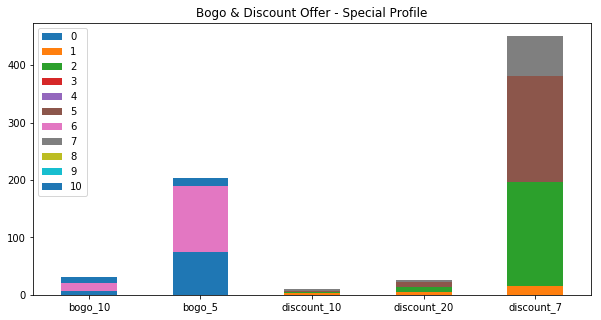

In [91]:
f, ax = plt.subplots(figsize=(10,5))
target_sp_summary.loc[:, target_sp_summary.columns.str.contains("bogo|discount")].T.plot(kind='bar',stacked=True,ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Bogo & Discount Offer - Special Profile');


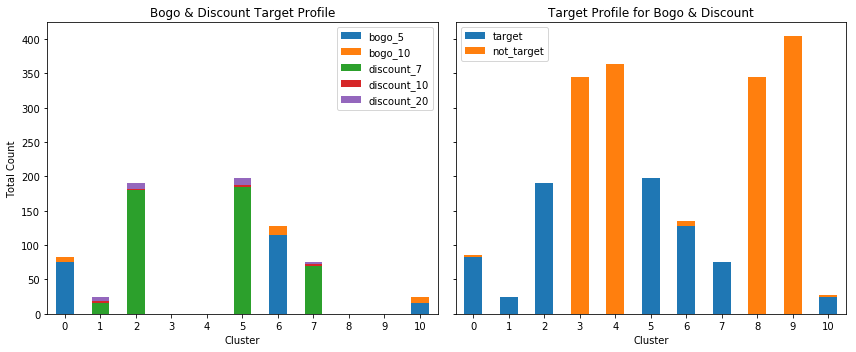

In [80]:
plot_assign_offer(target_sp_summary)

#### 8.2.2 Informational Offer

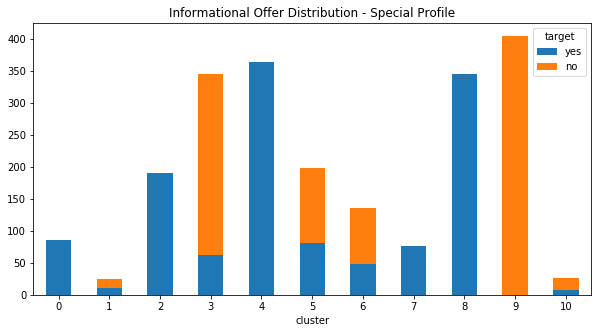

In [104]:
clust_info_sp = target_sp.copy()
clust_info_sp.loc[clust_info_sp.cluster.isin([0,2,4,7,8]), 'target'] = "yes"
clust_info_sp.loc[clust_info_sp['rate_viewed_informational'] >= 0.8, 'target'] = 'yes'
clust_info_sp['target'] = clust_info_sp['target'].fillna("no")

f, ax = plt.subplots(figsize=(10,5))
clust_info_sp.groupby(['cluster', 'target']).size().unstack()[['yes','no']].plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Informational Offer Distribution - Special Profile');

#### 8.2.3 Put it all together

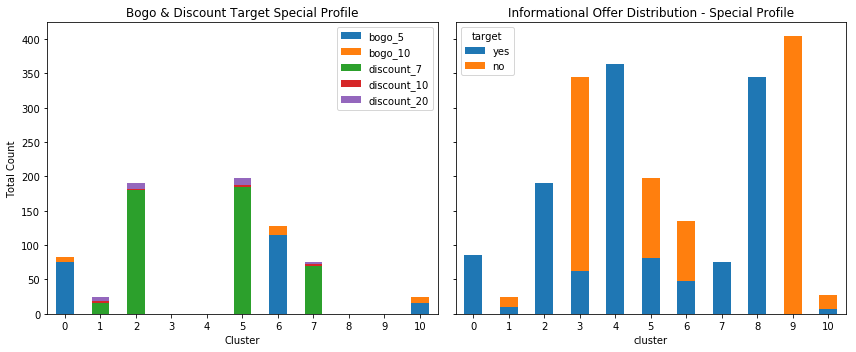

In [128]:
f, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5), sharey=True)

target_sp_summary[['bogo_5','bogo_10', 'discount_7', 'discount_10', 'discount_20']].plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0);
ax1.set_title('Bogo & Discount Target Special Profile')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Total Count')

clust_info_sp.groupby(['cluster', 'target']).size().unstack()[['yes','no']].plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0);
ax2.set_title('Informational Offer Distribution - Special Profile');

plt.tight_layout()

### 8.3 Summary Offer Type Distribution 

In [107]:
#main profile
main_series = target_main_summary.loc[:, target_main_summary.columns.str.contains("bogo|discount")].sum().rename('Main Profile')
main_series['informational'] = clust_info_main.groupby(['cluster', 'target']).size().unstack().sum()['yes']

#special profile 
sp_series = target_sp_summary.loc[:, target_sp_summary.columns.str.contains("bogo|discount")].sum().rename('Special Profile')
sp_series['informational'] = clust_info_sp.groupby(['cluster', 'target']).size().unstack().sum()['yes']

In [108]:
main_series

bogo_10           1981.0
bogo_5             688.0
discount_10        291.0
discount_20       2496.0
discount_7        1528.0
informational    11180.0
Name: Main Profile, dtype: float64

In [109]:
sp_series

bogo_10            31.0
bogo_5            204.0
discount_10        10.0
discount_20        26.0
discount_7        451.0
informational    1267.0
Name: Special Profile, dtype: float64

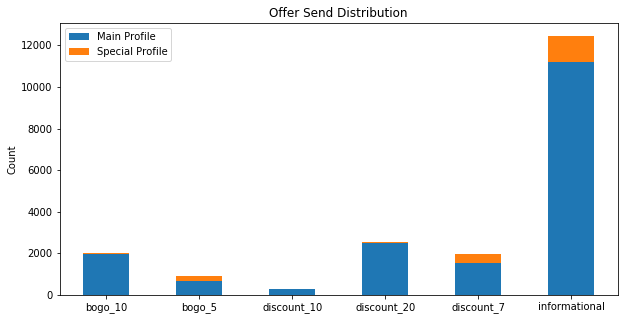

In [119]:
summary_df = pd.concat([main_series,sp_series], axis=1)

#bar plot
f, ax = plt.subplots(figsize=(10,5))
summary_df.plot(kind='bar', stacked=True, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_title('Offer Send Distribution');
ax.set_ylabel('Count');